In [38]:
import pandas as pd
import numpy as np
import scipy.linalg as la
import scipy.stats as stats
import statsmodels.api as sm
from sklearn import linear_model, model_selection, metrics
import sklearn
import plotly.graph_objs as go
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer, load_digits, load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.neighbors import KNeighborsClassifier as KNC
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as GDA
from sklearn.metrics import roc_auc_score as RAS
from sklearn.metrics import roc_curve as ROC
import seaborn as sns
from sklearn.manifold import TSNE
import umap

`jupyter nbconvert --to latex "Race and Incarceration in America.ipynb" --TagRemovePreprocessor.remove_input_tags='{"hide_input"}'; pdflatex "Race and Incarceration in America"`

# Introduction

Last semester I took a look a data set containing the information of more than 7.5 million individuals that have been processed by the criminal justice system. I found that racial minorities were more likely to receive extreme sentences, agreeing with existing research around bias in the criminal justice system. In this project I will be exploring the data from a machine learning perspective. My goal is to determine if this data can be classified in such a way that is predictive of race.

# Possible questions
can we use ml techniques to correctly classify this data?
which ones fail and why?
can we create a predictive model for sentence lengths?
should sentencing be offloaded to a ml algorithm.

In [14]:
chunksize = 100000
rdf = pd.read_csv('regression_df.csv', chunksize=chunksize)

In [39]:
# reducer = umap.UMAP()
# i = 0
# for item in rdf:
#     if i > 3:
#         break
#     else:
#         i += 1
        
#     data = item.drop(['Unnamed: 0','IDENTIFIER','LATEST ADMISSION DATE'], axis=1)
#     target = data[['AMER IND','ASIAN','BLACK','HISPANIC']]
#     data = data.drop(['AMER IND','ASIAN','BLACK','HISPANIC'], axis=1)
#     trans = reducer.fit_transform(data)
    
# #     create maskings
#     black = target.BLACK == 1
#     asian = target.ASIAN == 1
#     hisp = target.HISPANIC == 1
#     ind = target['AMER IND'] == 1
#     white = ~(black + asian + hisp)
    
#     plt.scatter(trans[:,0][black],trans[:,1][black],label='black',marker='.')
# #     plt.legend()
# #     plt.show()
#     plt.scatter(trans[:,0][white],trans[:,1][white],label='white',marker='.')
# #     plt.legend()
# #     plt.show()
#     plt.scatter(trans[:,0][hisp],trans[:,1][hisp],label='hisp',marker='.')
# #     plt.legend()
# #     plt.show()
#     plt.scatter(trans[:,0][ind],trans[:,1][ind],label='ind',marker='.')
# #     plt.legend()
# #     plt.show()
#     plt.scatter(trans[:,0][asian],trans[:,1][asian],label='asian',marker='.')
#     plt.legend()
#     plt.show()

In [29]:
cols = ['RACE','GENDER','AGE','OFFENSE','FACILITY','DETAINER','SENTENCE DAYS']
df = pd.read_csv('individuals.csv',usecols=cols)

/home/ethan/.local/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning:


The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../.local/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^


/home/ethan/.local/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning:

Embedding a total of 50 separate connected components using meta-embedding (experimental)

/home/ethan/.local/lib/python3.7/site-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.



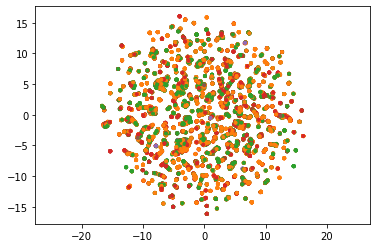

In [45]:
samp = df.sample(20000)
samp.RACE = pd.factorize(samp['RACE'])[0] + 1
samp.GENDER = pd.factorize(samp['GENDER'])[0] + 1
samp.OFFENSE = pd.factorize(samp['OFFENSE'])[0] + 1
samp.DETAINER = pd.factorize(samp['DETAINER'])[0] + 1
samp.FACILITY = pd.factorize(samp['FACILITY'])[0] + 1
samp_y = samp.RACE
samp_X = samp[['GENDER','AGE','OFFENSE','FACILITY','DETAINER','SENTENCE DAYS']]

trans = reducer.fit_transform(samp_X)

plt.scatter(trans[:, 0], trans[:, 1], c=[sns.color_palette()[x] for x in samp_y], marker='.')
plt.gca().set_aspect('equal', 'datalim')
plt.show()

It seems that UMAP doesnt work

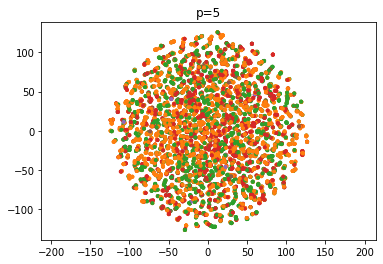

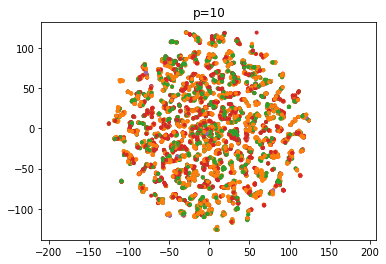

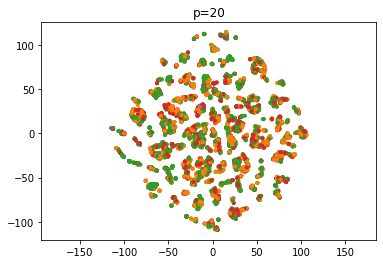

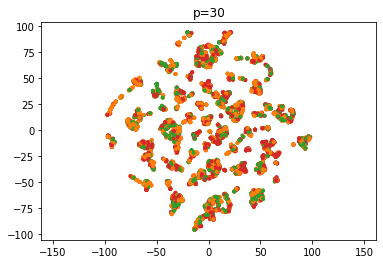

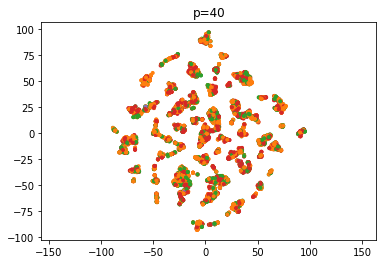

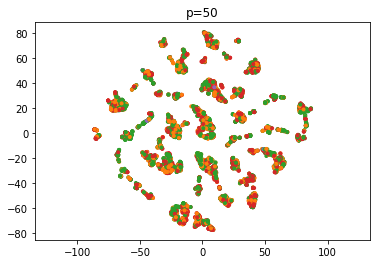

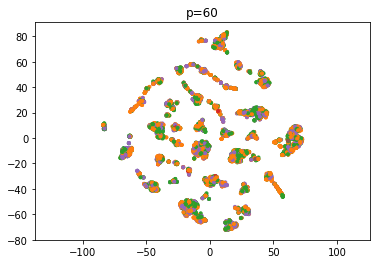

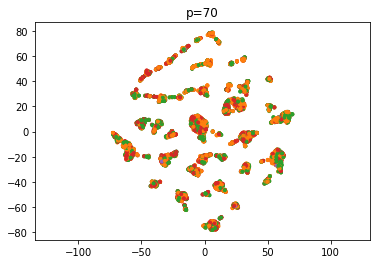

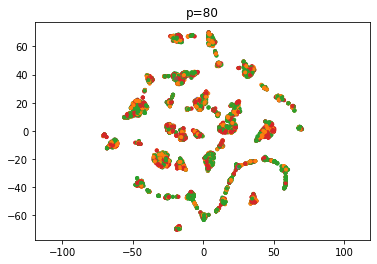

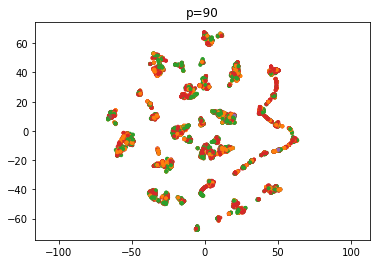

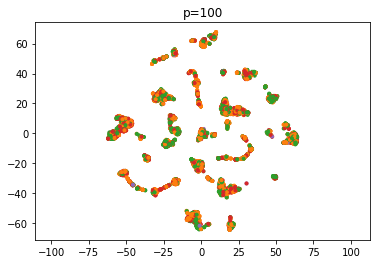

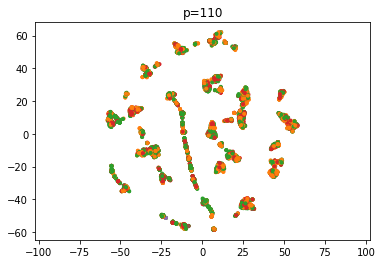

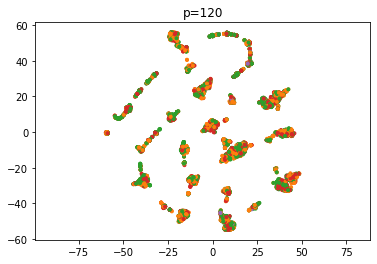

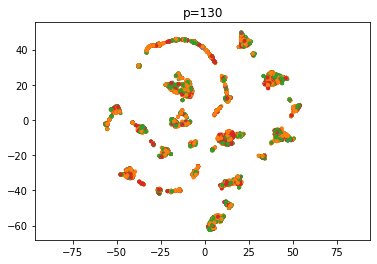

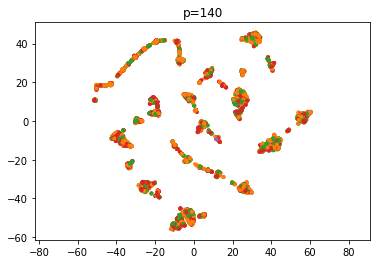

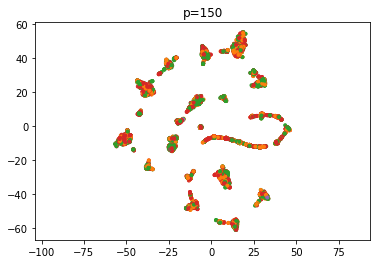

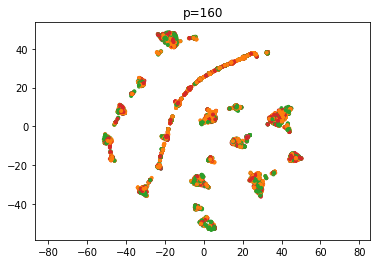

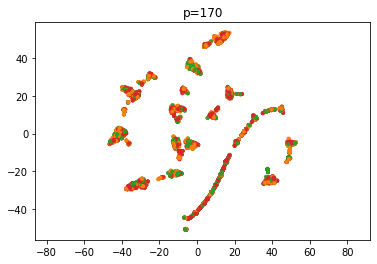

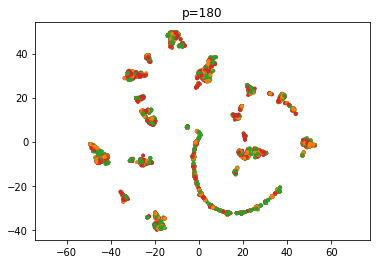

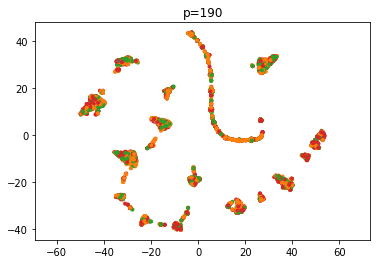

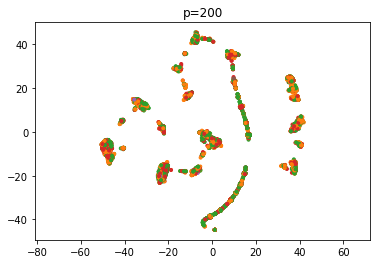

In [47]:
# params
ps = [5,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200]

for p in ps:
    
    samp = df.sample(8000)
    samp.RACE = pd.factorize(samp['RACE'])[0] + 1
    samp.GENDER = pd.factorize(samp['GENDER'])[0] + 1
    samp.OFFENSE = pd.factorize(samp['OFFENSE'])[0] + 1
    samp.DETAINER = pd.factorize(samp['DETAINER'])[0] + 1
    samp.FACILITY = pd.factorize(samp['FACILITY'])[0] + 1
    samp_y = samp.RACE
    samp_X = samp[['GENDER','AGE','OFFENSE','FACILITY','DETAINER','SENTENCE DAYS']]



    trans = TSNE(perplexity=p).fit_transform(samp_X)

    plt.scatter(trans[:, 0], trans[:, 1], c=[sns.color_palette()[x] for x in samp_y], marker='.')
    plt.gca().set_aspect('equal', 'datalim')
    plt.title(f'p={p}')
    plt.show()

/home/ethan/.local/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning:

Embedding a total of 5 separate connected components using meta-embedding (experimental)

/home/ethan/.local/lib/python3.7/site-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.



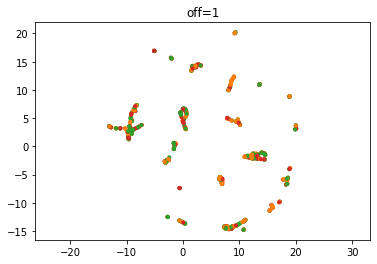

/home/ethan/.local/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning:

Embedding a total of 4 separate connected components using meta-embedding (experimental)



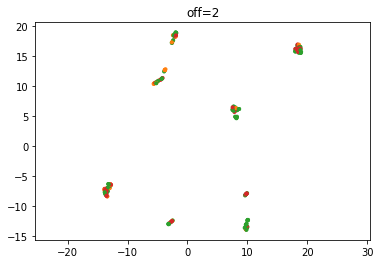

/home/ethan/.local/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning:

Embedding a total of 2 separate connected components using meta-embedding (experimental)



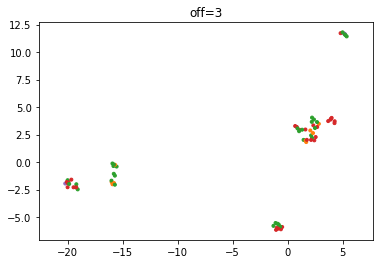

/home/ethan/.local/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning:

Embedding a total of 4 separate connected components using meta-embedding (experimental)



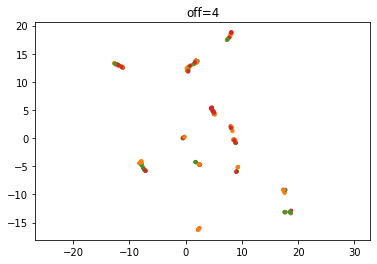

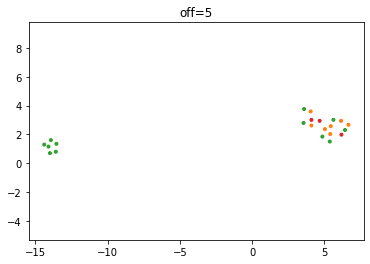

/home/ethan/.local/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning:

Embedding a total of 6 separate connected components using meta-embedding (experimental)

/home/ethan/.local/lib/python3.7/site-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.



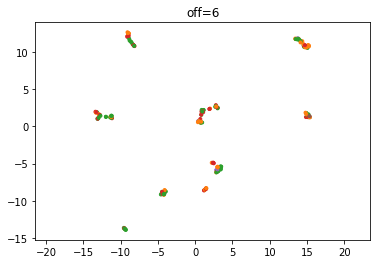

/home/ethan/.local/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning:

Embedding a total of 8 separate connected components using meta-embedding (experimental)

/home/ethan/.local/lib/python3.7/site-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.



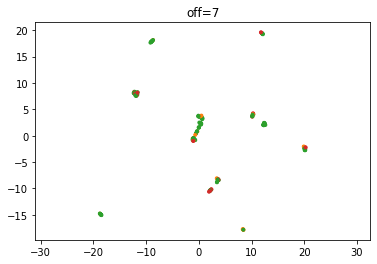

/home/ethan/.local/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning:

Embedding a total of 9 separate connected components using meta-embedding (experimental)

/home/ethan/.local/lib/python3.7/site-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.



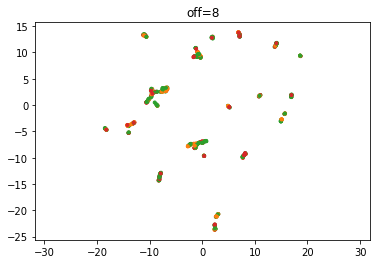

/home/ethan/.local/lib/python3.7/site-packages/umap/umap_.py:1383: UserWarning:

n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1

/home/ethan/.local/lib/python3.7/site-packages/scipy/sparse/linalg/eigen/arpack/arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.

/home/ethan/.local/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning:

Embedding a total of 3 separate connected components using meta-embedding (experimental)



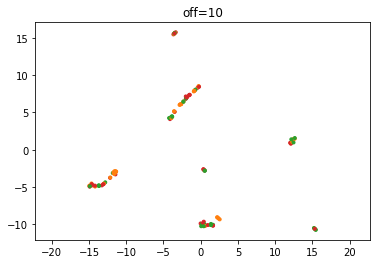

/home/ethan/.local/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning:

Embedding a total of 2 separate connected components using meta-embedding (experimental)



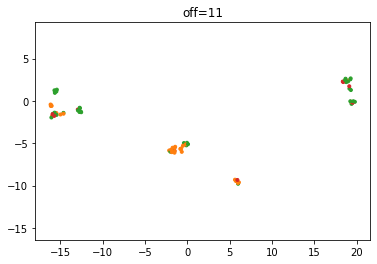

/home/ethan/.local/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning:

Embedding a total of 5 separate connected components using meta-embedding (experimental)

/home/ethan/.local/lib/python3.7/site-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.



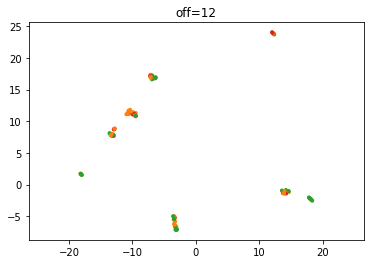

/home/ethan/.local/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning:

Embedding a total of 2 separate connected components using meta-embedding (experimental)



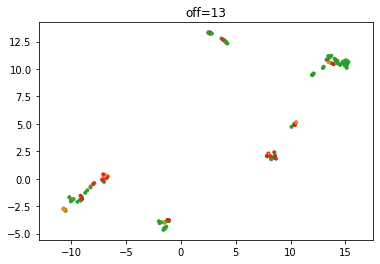

/home/ethan/.local/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning:

Embedding a total of 5 separate connected components using meta-embedding (experimental)

/home/ethan/.local/lib/python3.7/site-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.



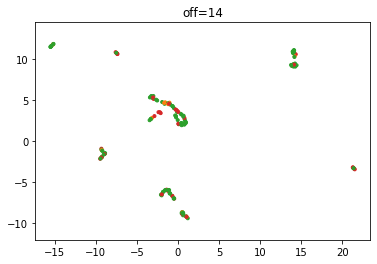

/home/ethan/.local/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning:

Embedding a total of 7 separate connected components using meta-embedding (experimental)

/home/ethan/.local/lib/python3.7/site-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.



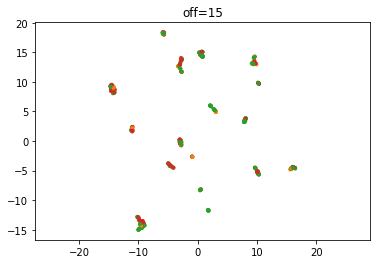

/home/ethan/.local/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning:

Embedding a total of 3 separate connected components using meta-embedding (experimental)



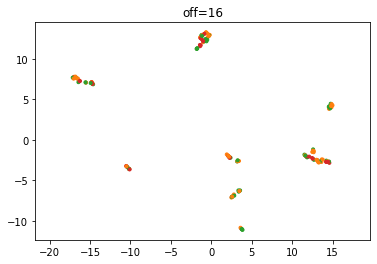

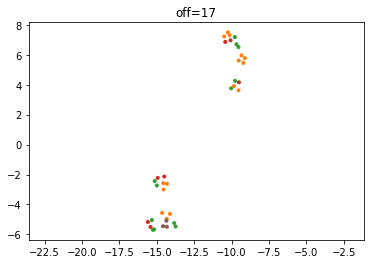

/home/ethan/.local/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning:

Embedding a total of 8 separate connected components using meta-embedding (experimental)

/home/ethan/.local/lib/python3.7/site-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.



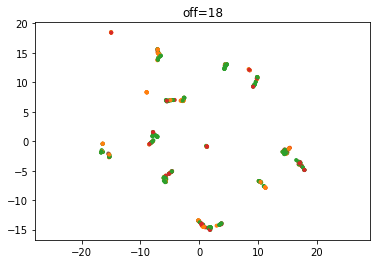

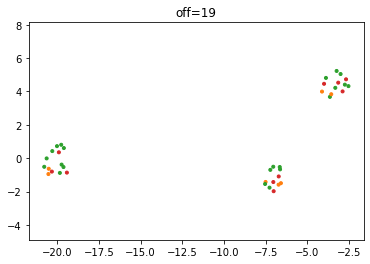

/home/ethan/.local/lib/python3.7/site-packages/umap/umap_.py:1383: UserWarning:

n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1



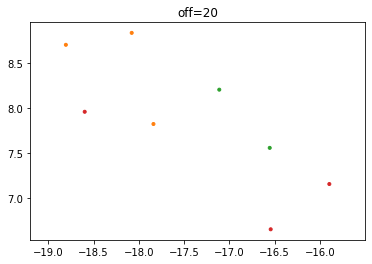

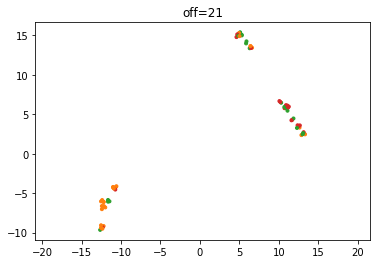

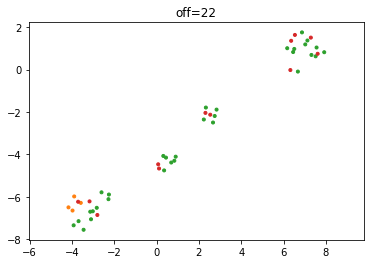

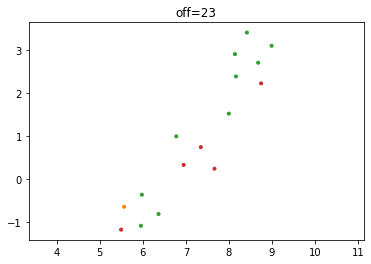

/home/ethan/.local/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning:

Embedding a total of 4 separate connected components using meta-embedding (experimental)



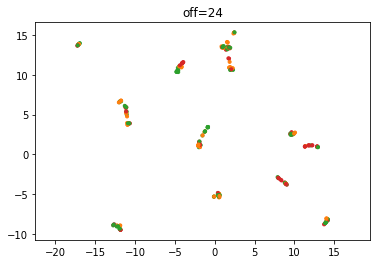

/home/ethan/.local/lib/python3.7/site-packages/umap/umap_.py:1383: UserWarning:

n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1



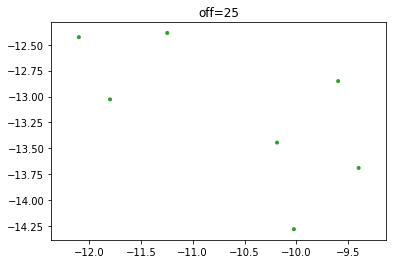

/home/ethan/.local/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning:

Embedding a total of 4 separate connected components using meta-embedding (experimental)



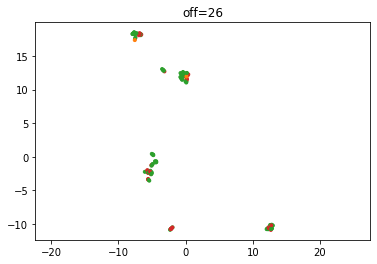

/home/ethan/.local/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning:

Embedding a total of 4 separate connected components using meta-embedding (experimental)



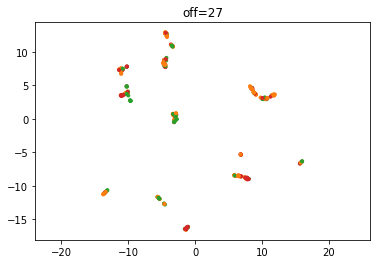

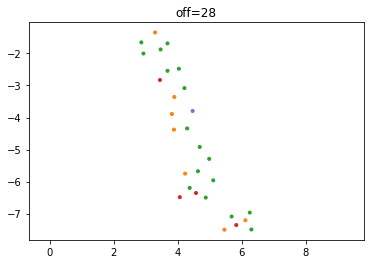

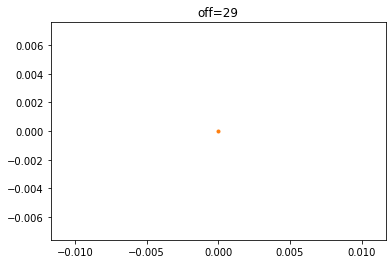

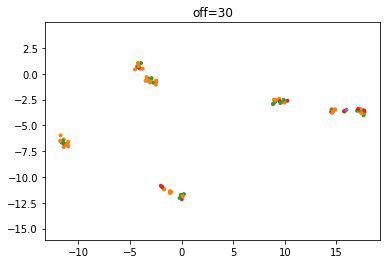

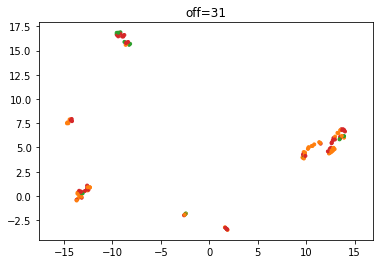

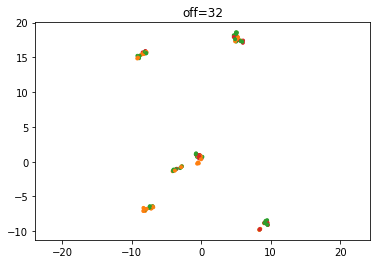

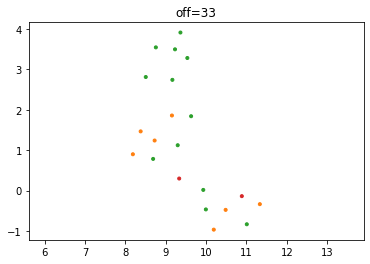

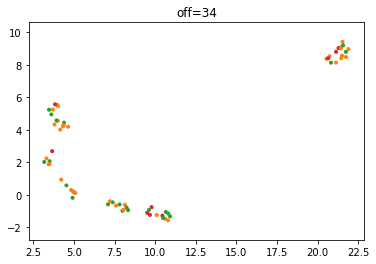

/home/ethan/.local/lib/python3.7/site-packages/umap/umap_.py:1383: UserWarning:

n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1



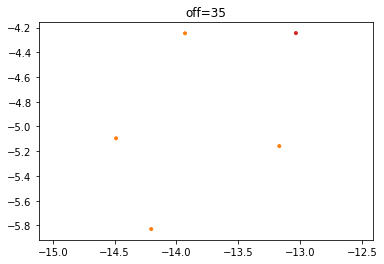

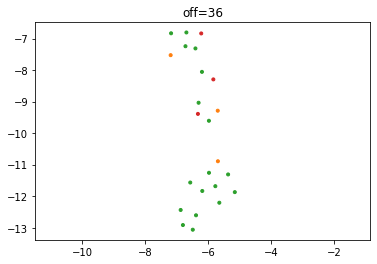

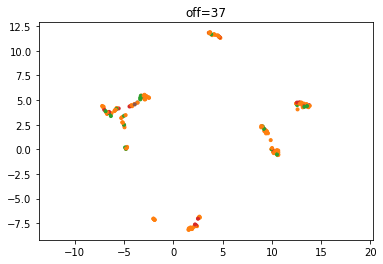

/home/ethan/.local/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning:

Embedding a total of 2 separate connected components using meta-embedding (experimental)



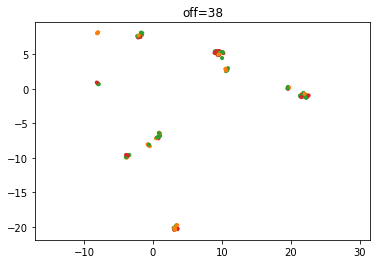

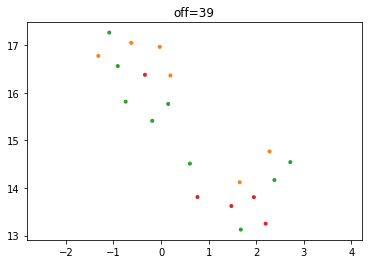

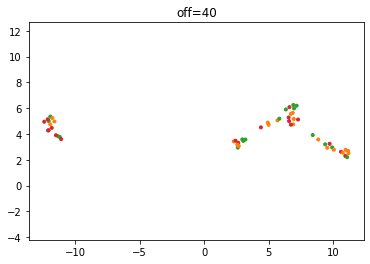

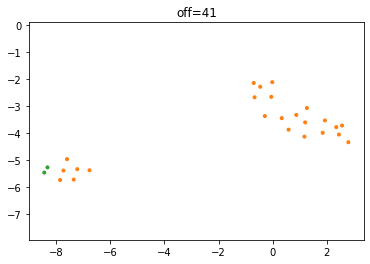

/home/ethan/.local/lib/python3.7/site-packages/umap/umap_.py:1383: UserWarning:

n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1



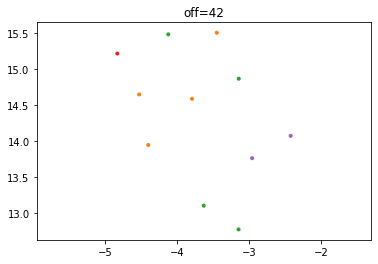

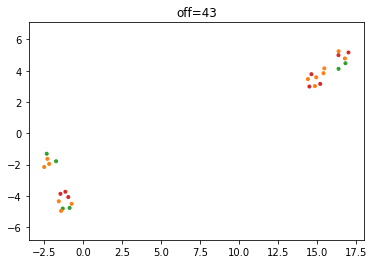

/home/ethan/.local/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning:

Embedding a total of 8 separate connected components using meta-embedding (experimental)

/home/ethan/.local/lib/python3.7/site-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.



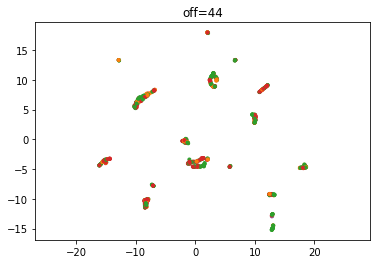

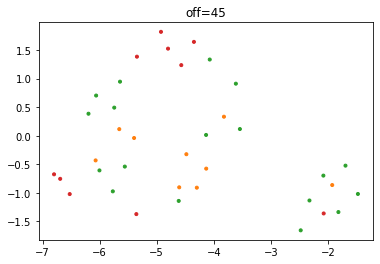

/home/ethan/.local/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning:

Embedding a total of 3 separate connected components using meta-embedding (experimental)



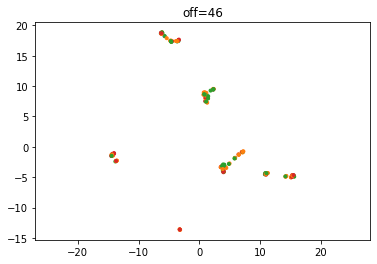

/home/ethan/.local/lib/python3.7/site-packages/umap/umap_.py:1383: UserWarning:

n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1



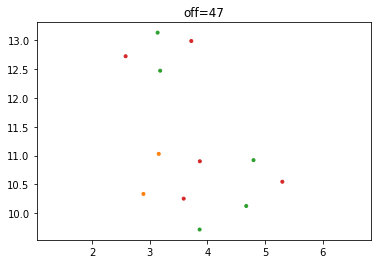

/home/ethan/.local/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning:

Embedding a total of 3 separate connected components using meta-embedding (experimental)



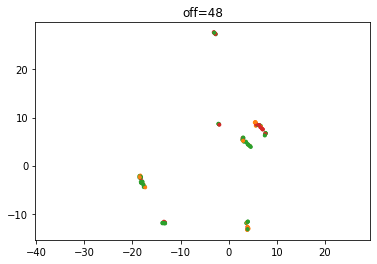

/home/ethan/.local/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning:

Embedding a total of 6 separate connected components using meta-embedding (experimental)

/home/ethan/.local/lib/python3.7/site-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.



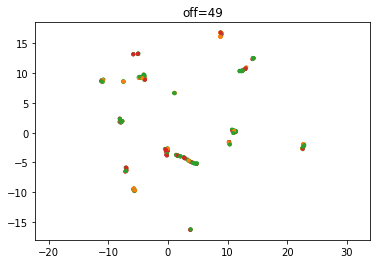

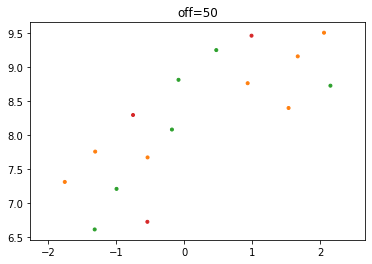

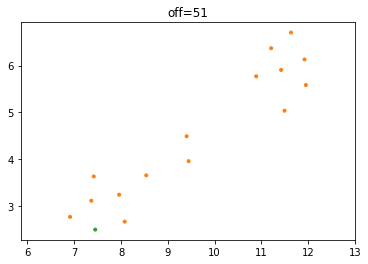

/home/ethan/.local/lib/python3.7/site-packages/umap/umap_.py:1383: UserWarning:

n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1



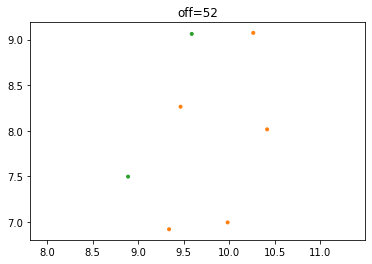

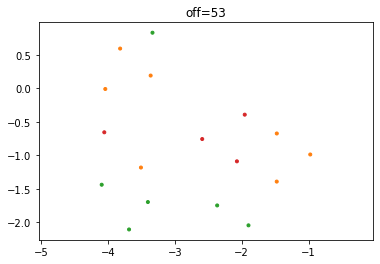

/home/ethan/.local/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning:

Embedding a total of 3 separate connected components using meta-embedding (experimental)



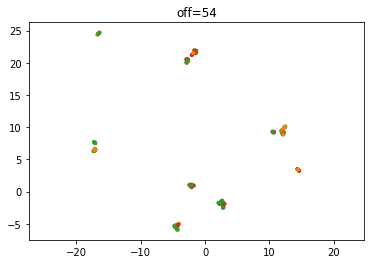

/home/ethan/.local/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning:

Embedding a total of 2 separate connected components using meta-embedding (experimental)



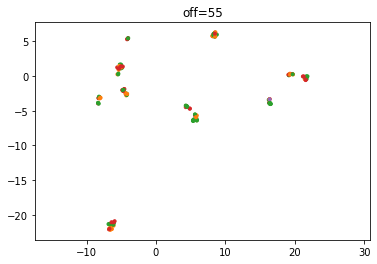

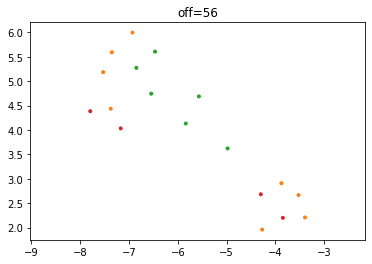

/home/ethan/.local/lib/python3.7/site-packages/umap/umap_.py:1383: UserWarning:

n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1



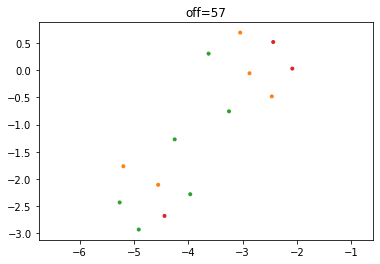

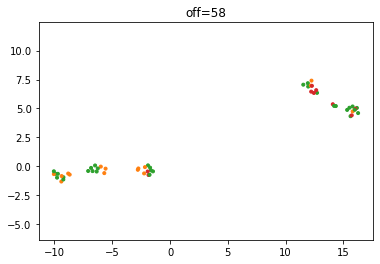

/home/ethan/.local/lib/python3.7/site-packages/umap/umap_.py:1383: UserWarning:

n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1

/home/ethan/.local/lib/python3.7/site-packages/scipy/sparse/linalg/eigen/arpack/arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.

/home/ethan/.local/lib/python3.7/site-packages/umap/umap_.py:1383: UserWarning:

n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1

/home/ethan/.local/lib/python3.7/site-packages/scipy/sparse/linalg/eigen/arpack/arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.

/home/ethan/.local/lib/python3.7/site-packages/umap/umap_.py:1383: UserWarning:

n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1



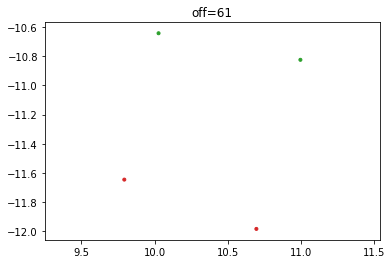

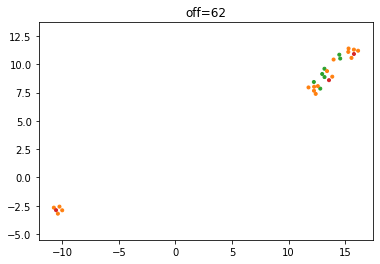

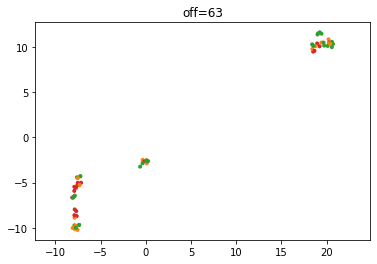

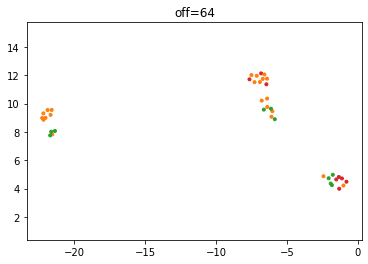

/home/ethan/.local/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning:

Embedding a total of 3 separate connected components using meta-embedding (experimental)



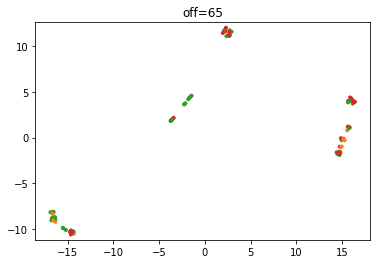

/home/ethan/.local/lib/python3.7/site-packages/umap/umap_.py:1383: UserWarning:

n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1



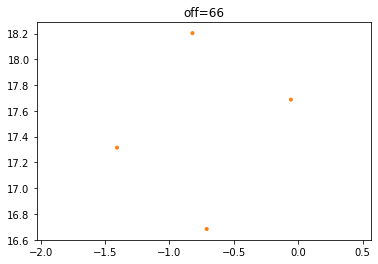

/home/ethan/.local/lib/python3.7/site-packages/umap/umap_.py:1383: UserWarning:

n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1



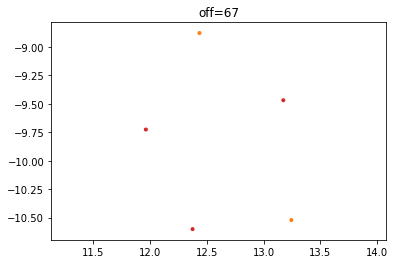

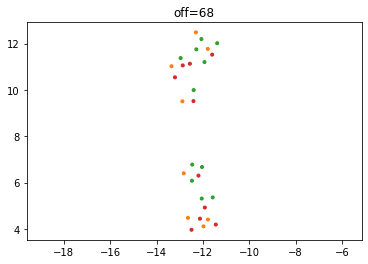

/home/ethan/.local/lib/python3.7/site-packages/umap/umap_.py:1383: UserWarning:

n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1



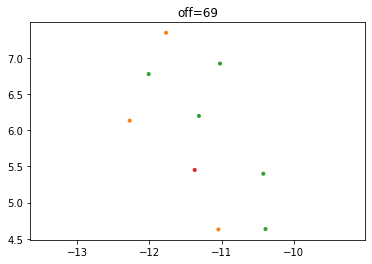

/home/ethan/.local/lib/python3.7/site-packages/umap/umap_.py:1383: UserWarning:

n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1



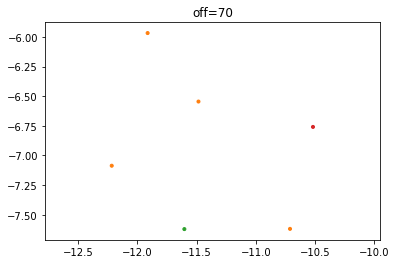

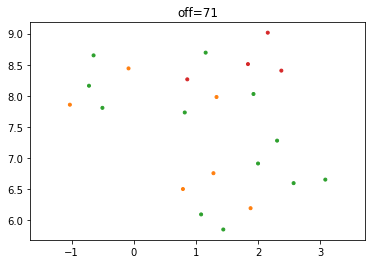

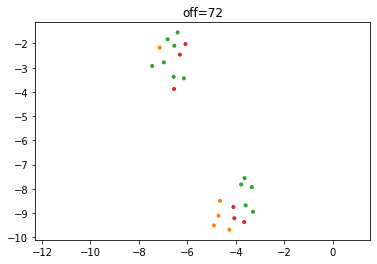

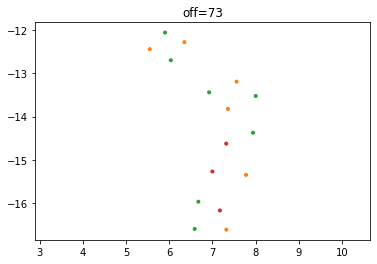

/home/ethan/.local/lib/python3.7/site-packages/umap/umap_.py:1383: UserWarning:

n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1



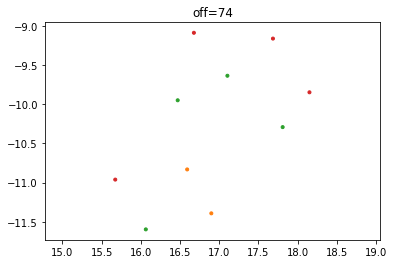

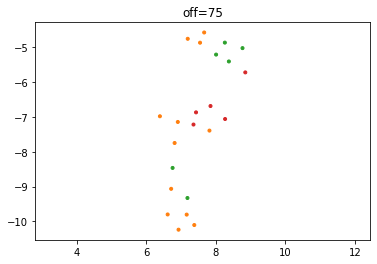

/home/ethan/.local/lib/python3.7/site-packages/umap/umap_.py:1383: UserWarning:

n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1



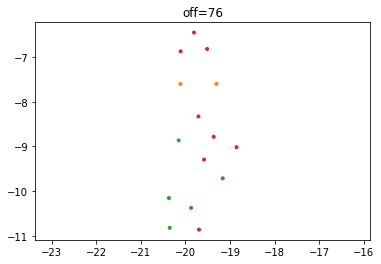

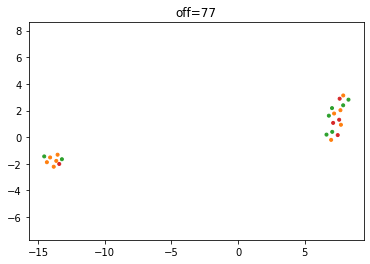

/home/ethan/.local/lib/python3.7/site-packages/umap/umap_.py:1383: UserWarning:

n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1



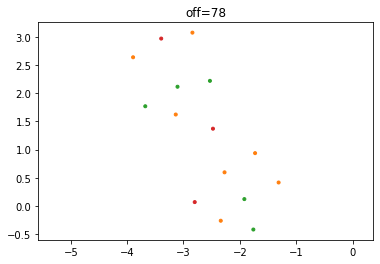

/home/ethan/.local/lib/python3.7/site-packages/umap/umap_.py:1383: UserWarning:

n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1



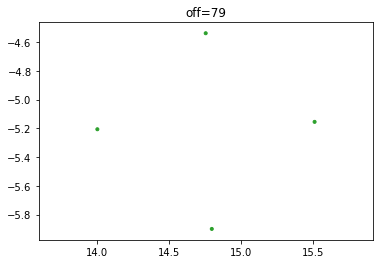

/home/ethan/.local/lib/python3.7/site-packages/umap/umap_.py:1383: UserWarning:

n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1



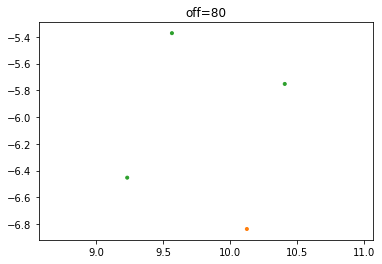

/home/ethan/.local/lib/python3.7/site-packages/umap/umap_.py:1383: UserWarning:

n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1



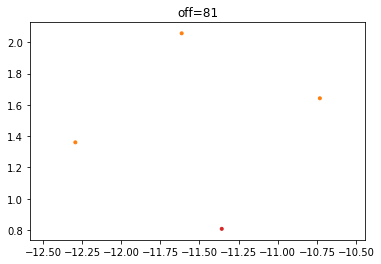

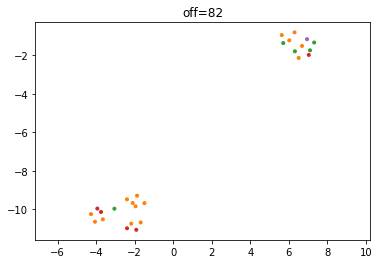

/home/ethan/.local/lib/python3.7/site-packages/umap/umap_.py:1383: UserWarning:

n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1



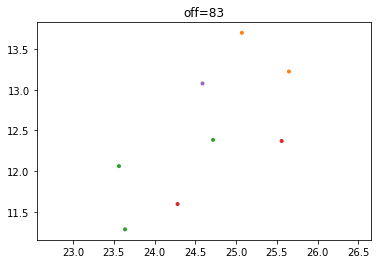

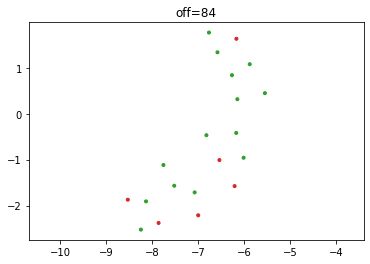

/home/ethan/.local/lib/python3.7/site-packages/umap/umap_.py:1383: UserWarning:

n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1



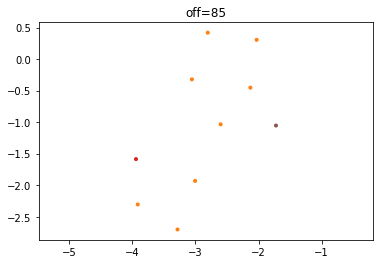

/home/ethan/.local/lib/python3.7/site-packages/umap/umap_.py:1383: UserWarning:

n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1



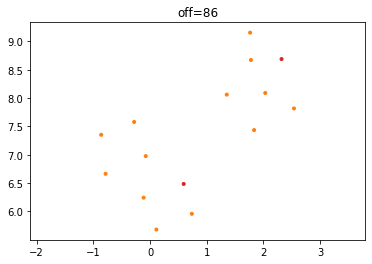

/home/ethan/.local/lib/python3.7/site-packages/umap/umap_.py:1383: UserWarning:

n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1



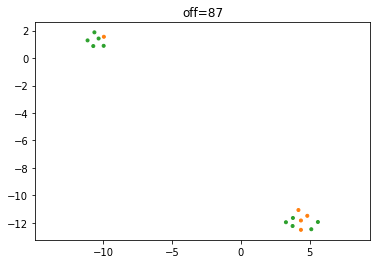

/home/ethan/.local/lib/python3.7/site-packages/umap/umap_.py:1383: UserWarning:

n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1



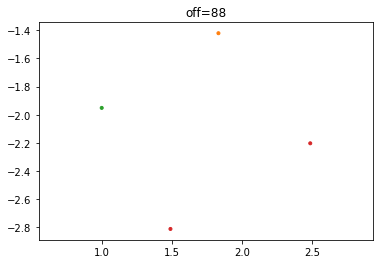

/home/ethan/.local/lib/python3.7/site-packages/umap/umap_.py:1383: UserWarning:

n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1



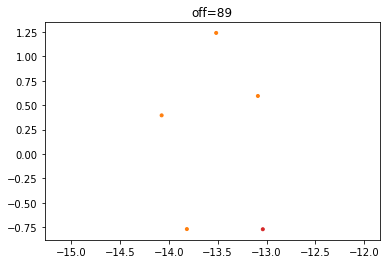

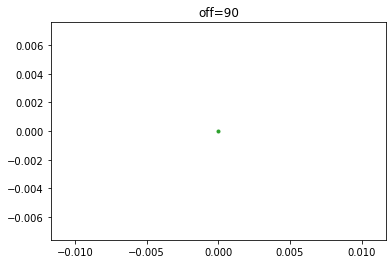

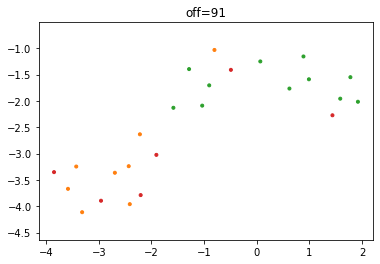

/home/ethan/.local/lib/python3.7/site-packages/umap/umap_.py:1383: UserWarning:

n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1

/home/ethan/.local/lib/python3.7/site-packages/scipy/sparse/linalg/eigen/arpack/arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.

/home/ethan/.local/lib/python3.7/site-packages/umap/umap_.py:1383: UserWarning:

n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1



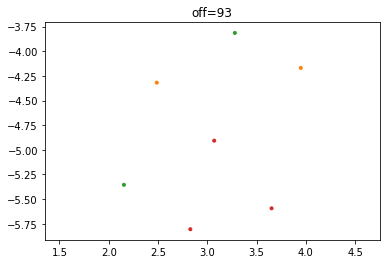

/home/ethan/.local/lib/python3.7/site-packages/umap/umap_.py:1383: UserWarning:

n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1

/home/ethan/.local/lib/python3.7/site-packages/umap/umap_.py:1383: UserWarning:

n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1



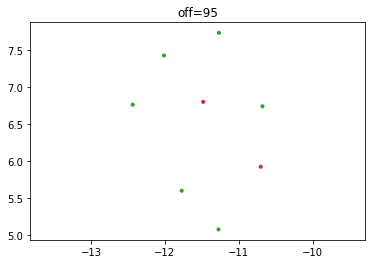

/home/ethan/.local/lib/python3.7/site-packages/umap/umap_.py:1383: UserWarning:

n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1



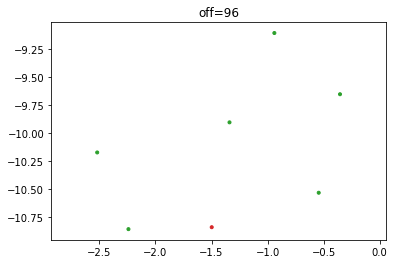

/home/ethan/.local/lib/python3.7/site-packages/umap/umap_.py:1383: UserWarning:

n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1



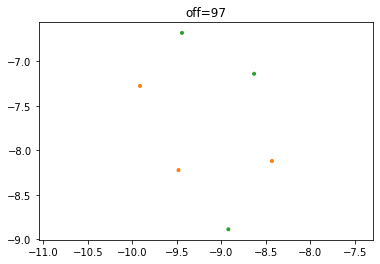

/home/ethan/.local/lib/python3.7/site-packages/umap/umap_.py:1383: UserWarning:

n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1



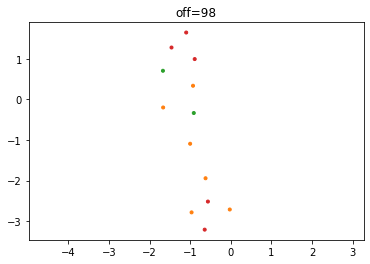

/home/ethan/.local/lib/python3.7/site-packages/umap/umap_.py:1383: UserWarning:

n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1

/home/ethan/.local/lib/python3.7/site-packages/umap/umap_.py:1383: UserWarning:

n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1



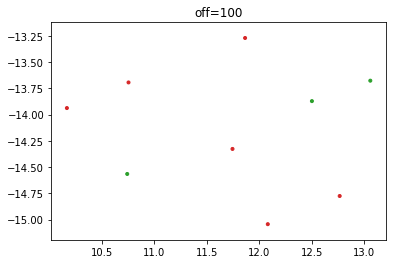

/home/ethan/.local/lib/python3.7/site-packages/umap/umap_.py:1383: UserWarning:

n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1

/home/ethan/.local/lib/python3.7/site-packages/umap/umap_.py:1383: UserWarning:

n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1



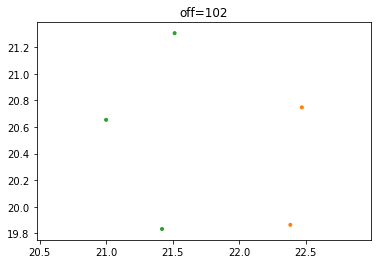

/home/ethan/.local/lib/python3.7/site-packages/umap/umap_.py:1383: UserWarning:

n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1



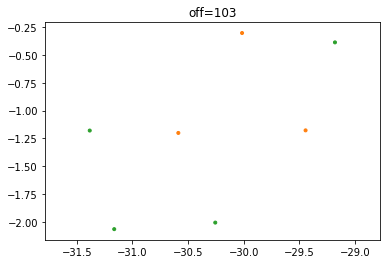

/home/ethan/.local/lib/python3.7/site-packages/umap/umap_.py:1383: UserWarning:

n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1

/home/ethan/.local/lib/python3.7/site-packages/scipy/sparse/linalg/eigen/arpack/arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.

/home/ethan/.local/lib/python3.7/site-packages/umap/umap_.py:1383: UserWarning:

n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1



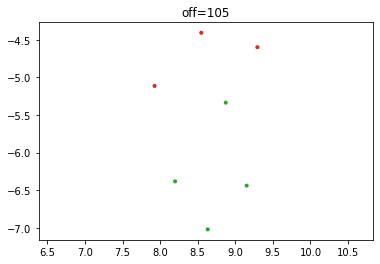

/home/ethan/.local/lib/python3.7/site-packages/umap/umap_.py:1383: UserWarning:

n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1



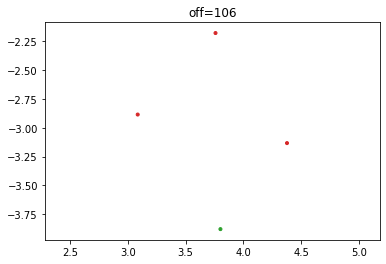

/home/ethan/.local/lib/python3.7/site-packages/umap/umap_.py:1383: UserWarning:

n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1

/home/ethan/.local/lib/python3.7/site-packages/scipy/sparse/linalg/eigen/arpack/arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.

/home/ethan/.local/lib/python3.7/site-packages/umap/umap_.py:1383: UserWarning:

n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1

/home/ethan/.local/lib/python3.7/site-packages/scipy/sparse/linalg/eigen/arpack/arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.

/home/ethan/.local/lib/python3.7/site-packages/umap/umap_.py:1383: UserWarning:

n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1



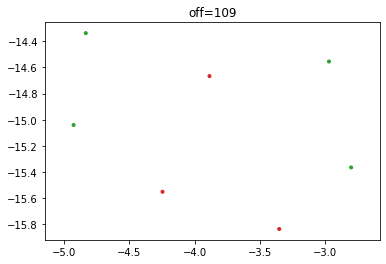

/home/ethan/.local/lib/python3.7/site-packages/umap/umap_.py:1383: UserWarning:

n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1



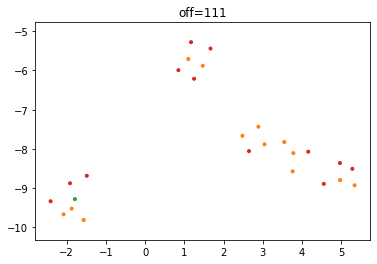

/home/ethan/.local/lib/python3.7/site-packages/umap/umap_.py:1383: UserWarning:

n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1



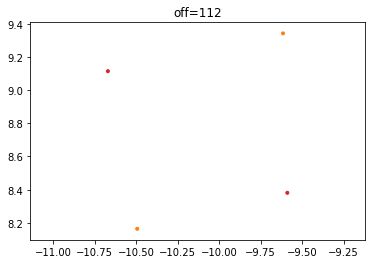

/home/ethan/.local/lib/python3.7/site-packages/umap/umap_.py:1383: UserWarning:

n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1



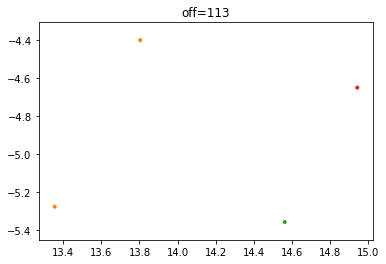

/home/ethan/.local/lib/python3.7/site-packages/umap/umap_.py:1383: UserWarning:

n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1



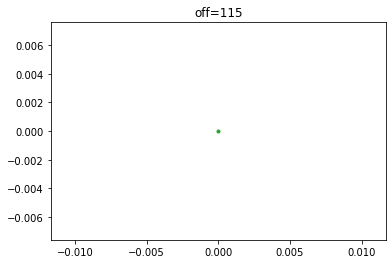

/home/ethan/.local/lib/python3.7/site-packages/umap/umap_.py:1383: UserWarning:

n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1

/home/ethan/.local/lib/python3.7/site-packages/umap/umap_.py:1383: UserWarning:

n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1



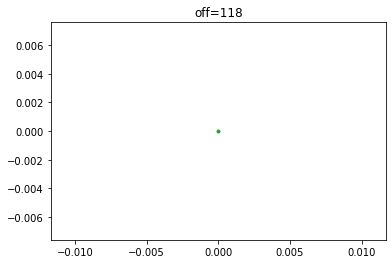

/home/ethan/.local/lib/python3.7/site-packages/umap/umap_.py:1383: UserWarning:

n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1



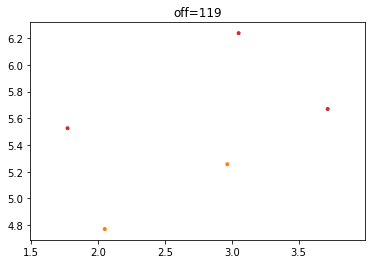

/home/ethan/.local/lib/python3.7/site-packages/umap/umap_.py:1383: UserWarning:

n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1

/home/ethan/.local/lib/python3.7/site-packages/scipy/sparse/linalg/eigen/arpack/arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



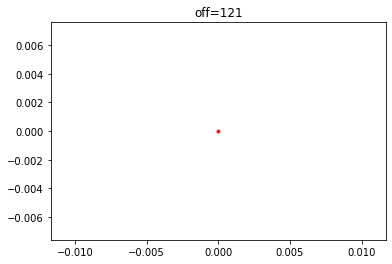

/home/ethan/.local/lib/python3.7/site-packages/umap/umap_.py:1383: UserWarning:

n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1



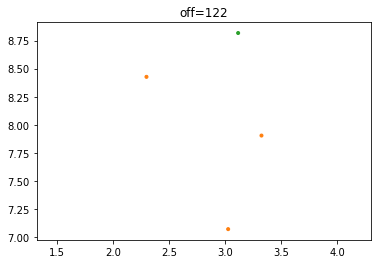

/home/ethan/.local/lib/python3.7/site-packages/umap/umap_.py:1383: UserWarning:

n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1



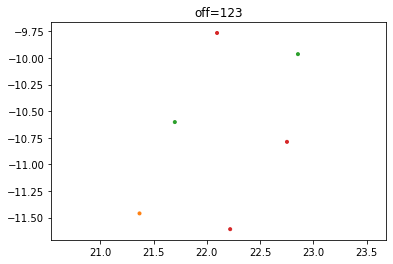

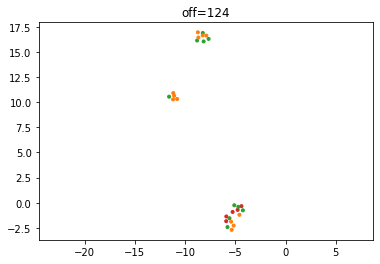

/home/ethan/.local/lib/python3.7/site-packages/umap/umap_.py:1383: UserWarning:

n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1

/home/ethan/.local/lib/python3.7/site-packages/scipy/sparse/linalg/eigen/arpack/arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.

/home/ethan/.local/lib/python3.7/site-packages/umap/umap_.py:1383: UserWarning:

n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1

/home/ethan/.local/lib/python3.7/site-packages/umap/umap_.py:1383: UserWarning:

n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1



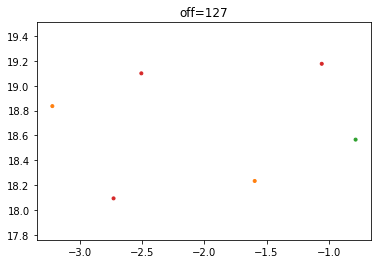

/home/ethan/.local/lib/python3.7/site-packages/umap/umap_.py:1383: UserWarning:

n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1

/home/ethan/.local/lib/python3.7/site-packages/umap/umap_.py:1383: UserWarning:

n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1

/home/ethan/.local/lib/python3.7/site-packages/scipy/sparse/linalg/eigen/arpack/arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.

/home/ethan/.local/lib/python3.7/site-packages/umap/umap_.py:1383: UserWarning:

n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1

/home/ethan/.local/lib/python3.7/site-packages/umap/umap_.py:1383: UserWarning:

n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1

/home/ethan/.local/lib/python3.7/site-packages/scipy/sparse/linalg/eigen/arpack/arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh inst

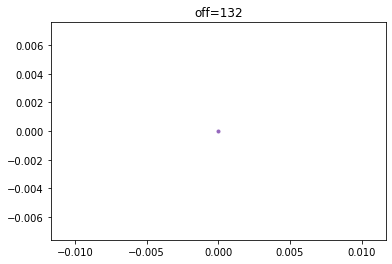

/home/ethan/.local/lib/python3.7/site-packages/umap/umap_.py:1383: UserWarning:

n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1

/home/ethan/.local/lib/python3.7/site-packages/umap/umap_.py:1383: UserWarning:

n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1

/home/ethan/.local/lib/python3.7/site-packages/umap/umap_.py:1383: UserWarning:

n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1

/home/ethan/.local/lib/python3.7/site-packages/umap/umap_.py:1383: UserWarning:

n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1

/home/ethan/.local/lib/python3.7/site-packages/scipy/sparse/linalg/eigen/arpack/arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.

/home/ethan/.local/lib/python3.7/site-packages/umap/umap_.py:1383: UserWarning:

n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1



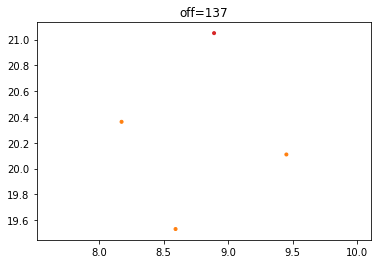

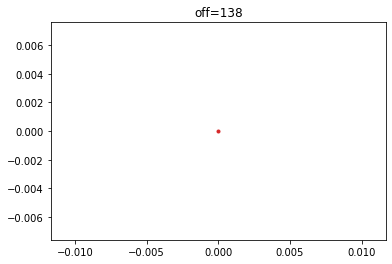

/home/ethan/.local/lib/python3.7/site-packages/umap/umap_.py:1383: UserWarning:

n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1



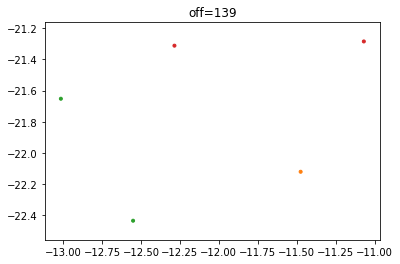

/home/ethan/.local/lib/python3.7/site-packages/umap/umap_.py:1383: UserWarning:

n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1



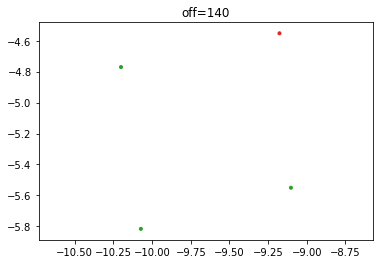

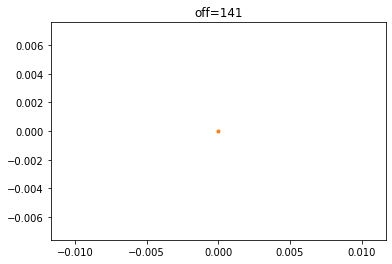

/home/ethan/.local/lib/python3.7/site-packages/umap/umap_.py:1383: UserWarning:

n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1



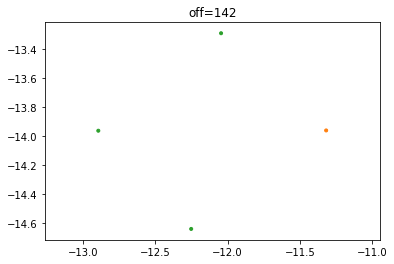

/home/ethan/.local/lib/python3.7/site-packages/umap/umap_.py:1383: UserWarning:

n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1

/home/ethan/.local/lib/python3.7/site-packages/scipy/sparse/linalg/eigen/arpack/arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.

/home/ethan/.local/lib/python3.7/site-packages/umap/umap_.py:1383: UserWarning:

n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1

/home/ethan/.local/lib/python3.7/site-packages/scipy/sparse/linalg/eigen/arpack/arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.

/home/ethan/.local/lib/python3.7/site-packages/umap/umap_.py:1383: UserWarning:

n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1



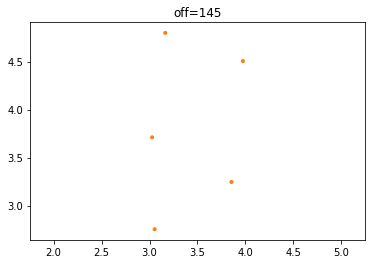

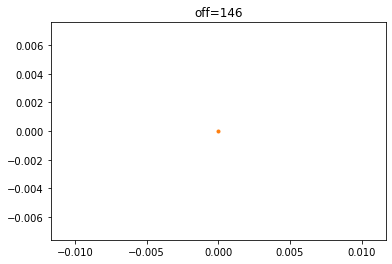

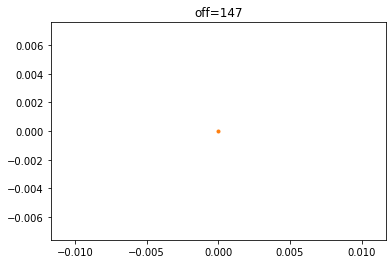

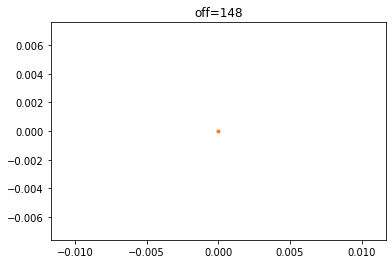

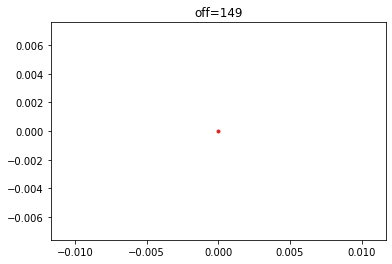

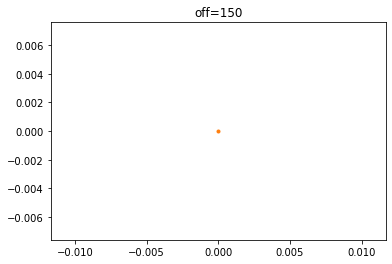

/home/ethan/.local/lib/python3.7/site-packages/umap/umap_.py:1383: UserWarning:

n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1

/home/ethan/.local/lib/python3.7/site-packages/scipy/sparse/linalg/eigen/arpack/arpack.py:1592: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.

/home/ethan/.local/lib/python3.7/site-packages/umap/umap_.py:1383: UserWarning:

n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1



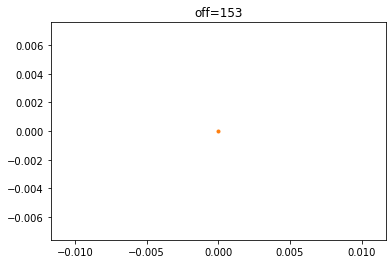

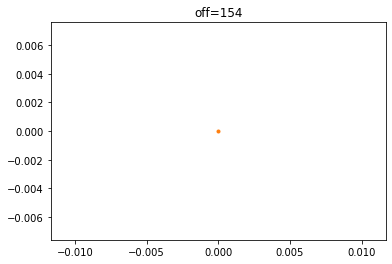

/home/ethan/.local/lib/python3.7/site-packages/umap/umap_.py:1383: UserWarning:

n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1



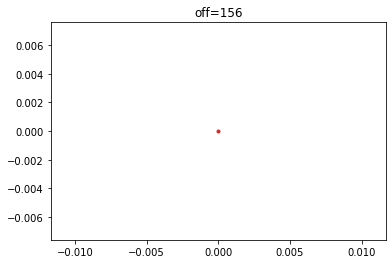

/home/ethan/.local/lib/python3.7/site-packages/umap/umap_.py:1383: UserWarning:

n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1



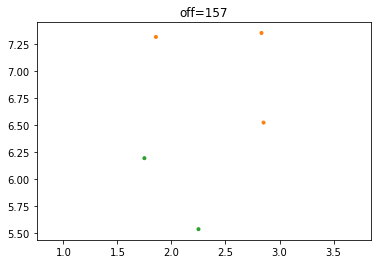

/home/ethan/.local/lib/python3.7/site-packages/umap/umap_.py:1383: UserWarning:

n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1



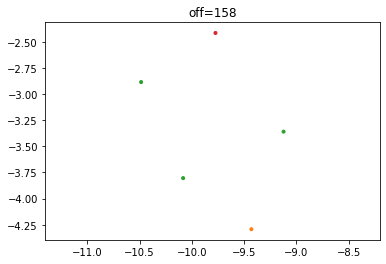

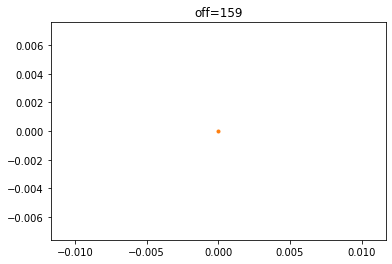

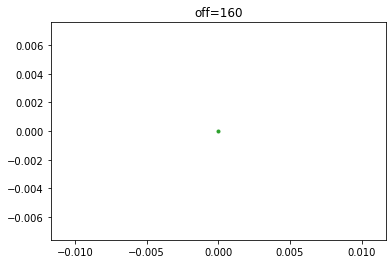

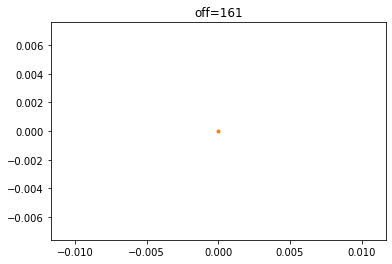

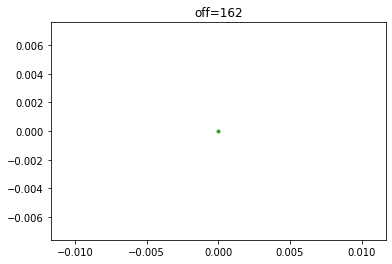

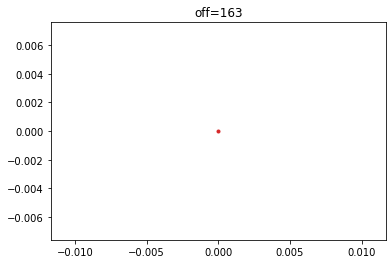

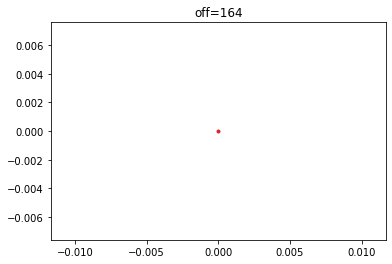

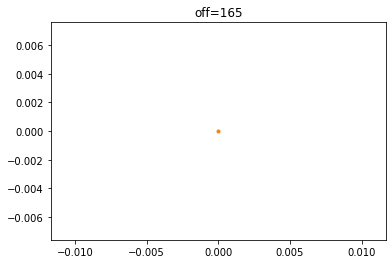

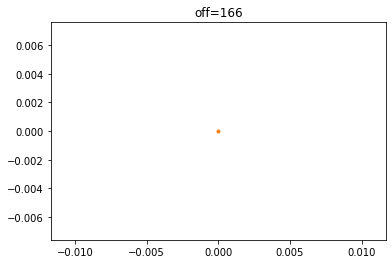

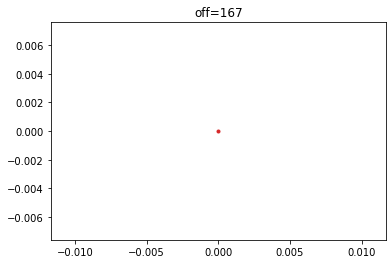

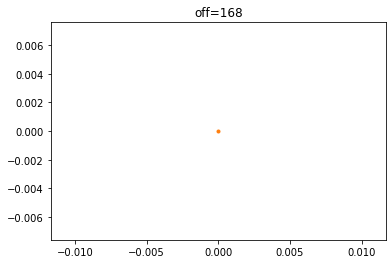

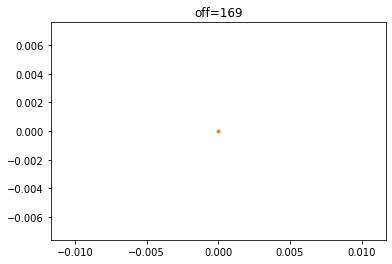

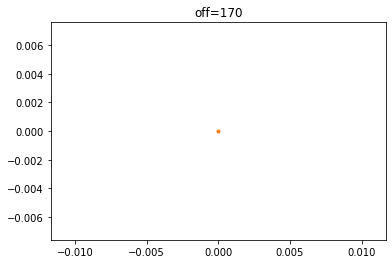

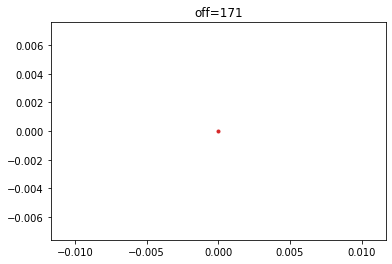

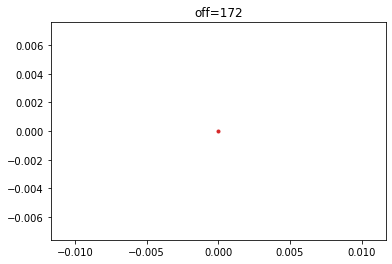

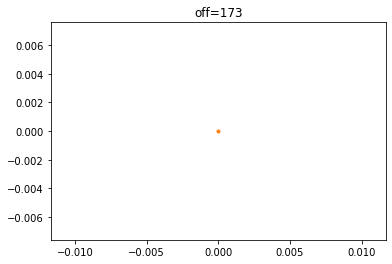

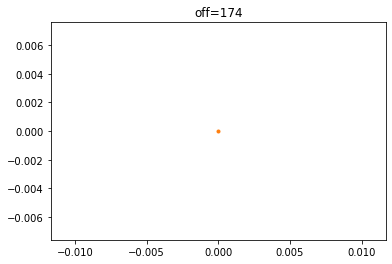

In [70]:
for off in set(samp.OFFENSE):
    
    mask = samp_X.OFFENSE == off
    
    data = samp_X[mask]
    
#     trans = TSNE(perplexity=20).fit_transform(data)
    try:
        trans = reducer.fit_transform(data.values)

        plt.scatter(trans[:, 0], trans[:, 1], c=[sns.color_palette()[x] for x in samp_y[mask]], marker='.')
        plt.gca().set_aspect('equal', 'datalim')
        plt.title(f'off={off}')
        plt.show()
    except:
        
        continue
    
    

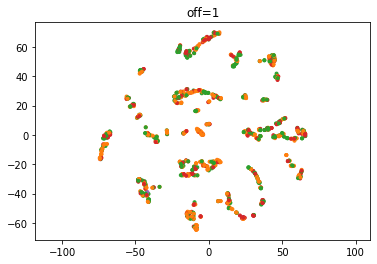

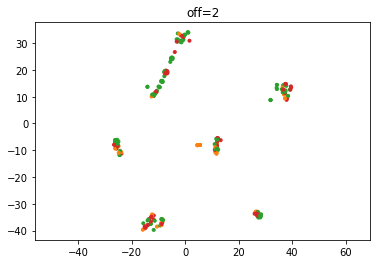

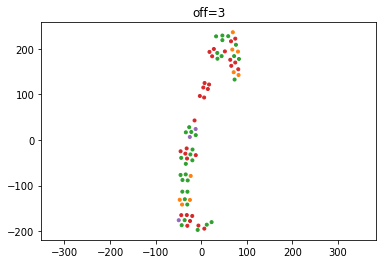

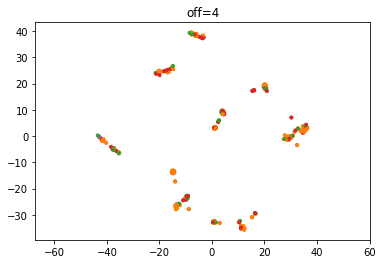

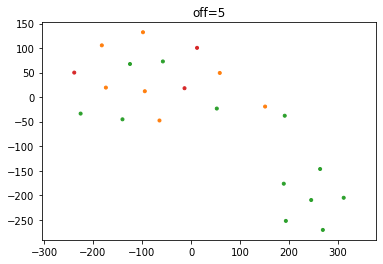

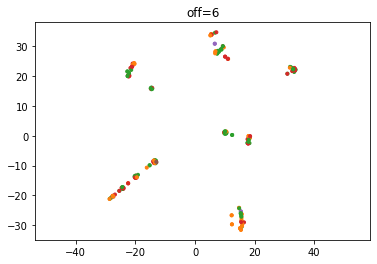

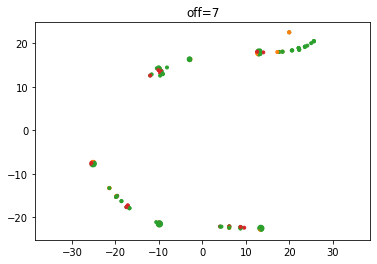

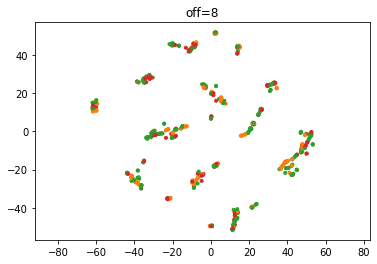

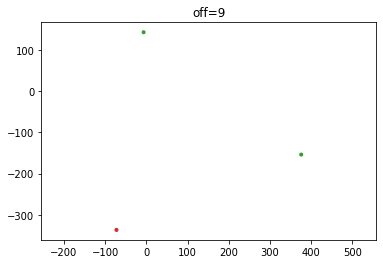

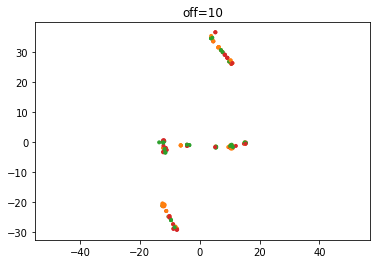

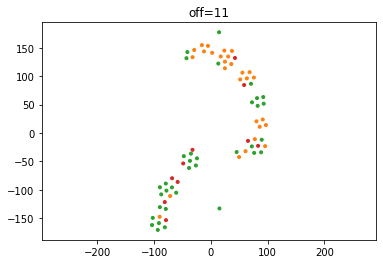

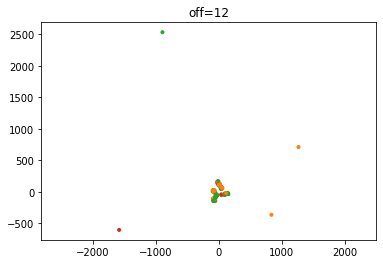

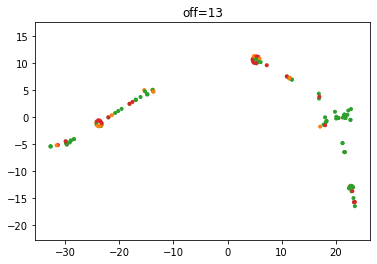

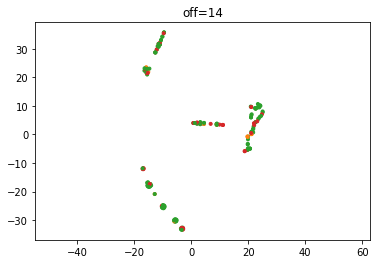

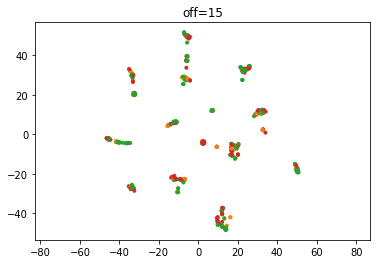

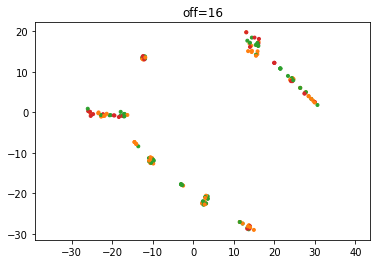

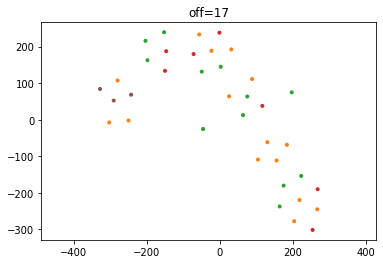

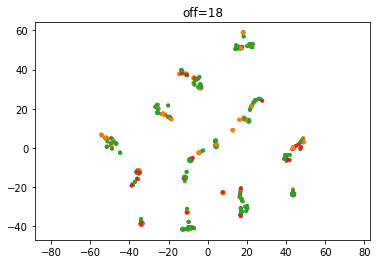

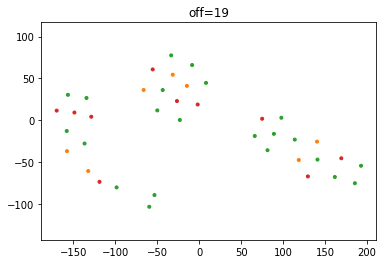

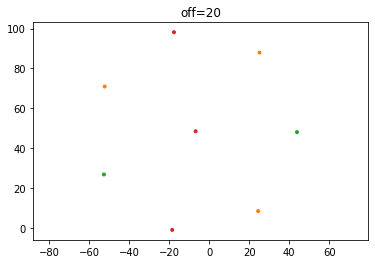

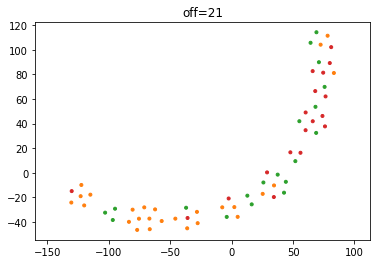

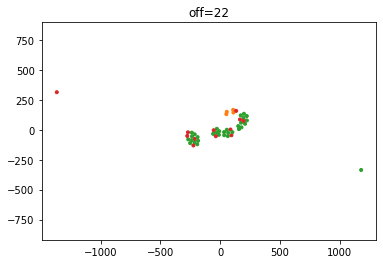

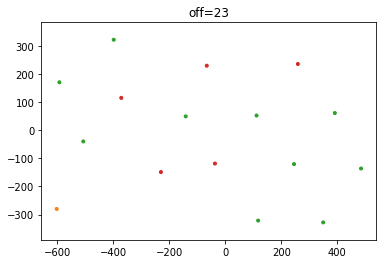

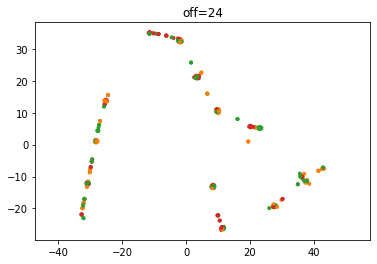

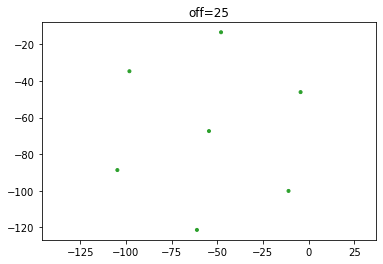

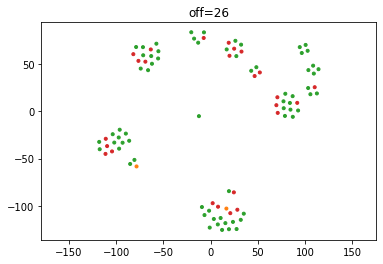

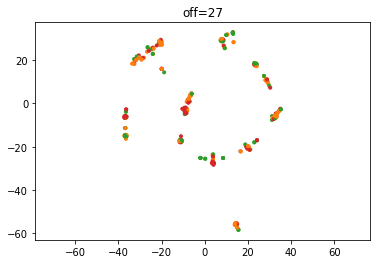

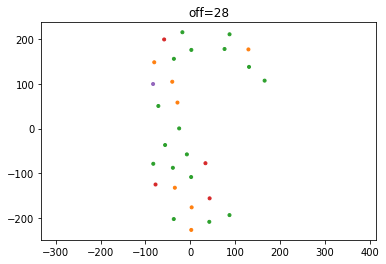

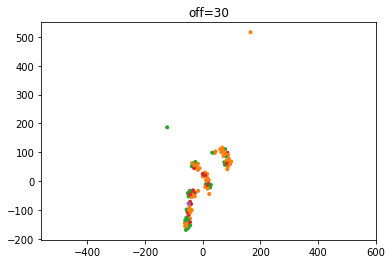

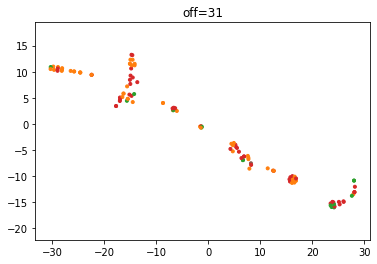

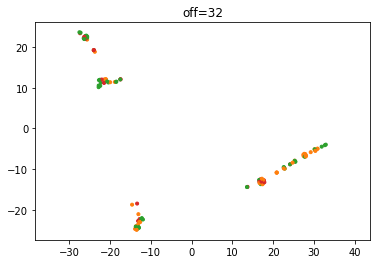

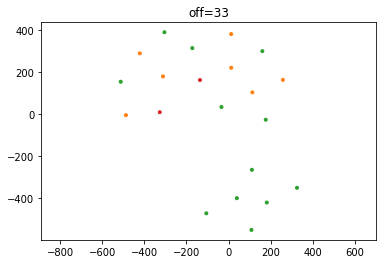

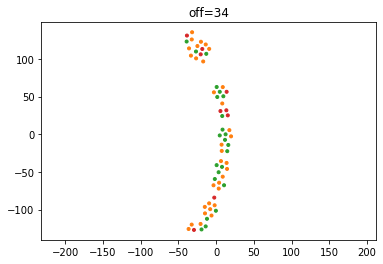

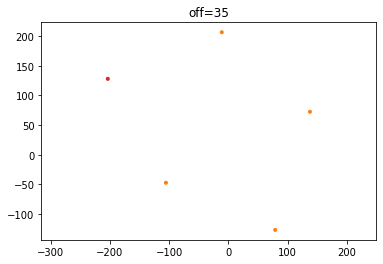

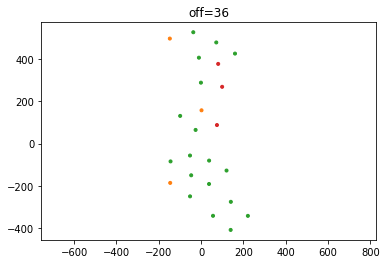

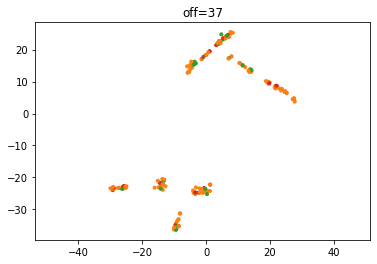

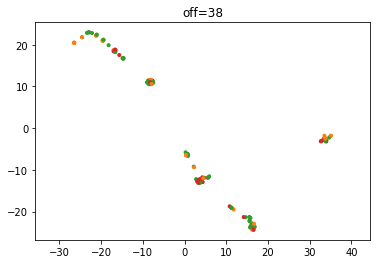

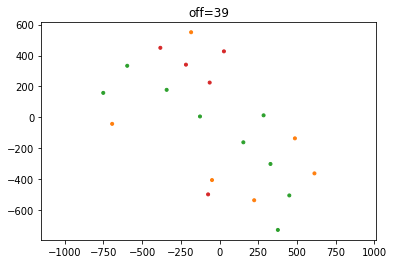

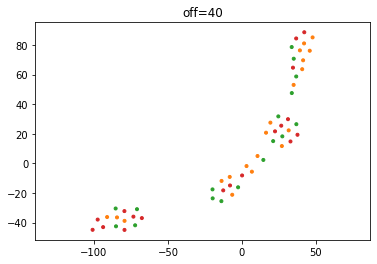

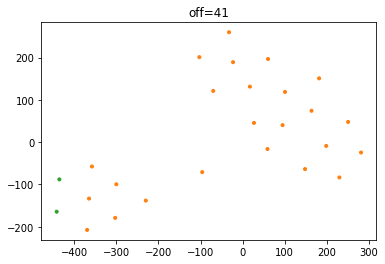

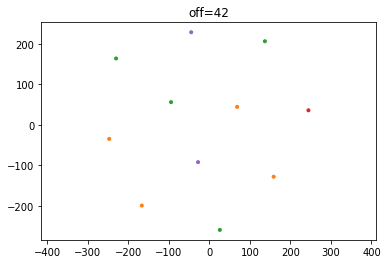

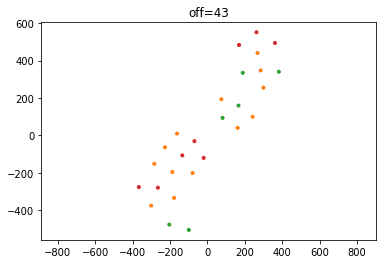

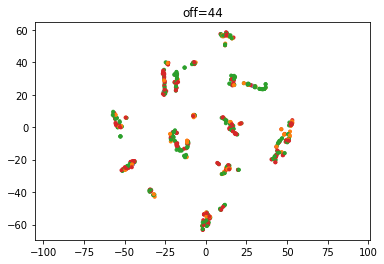

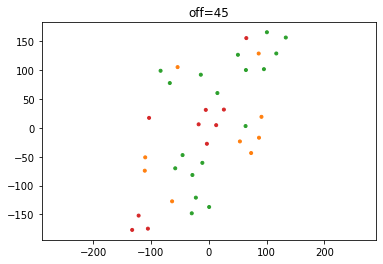

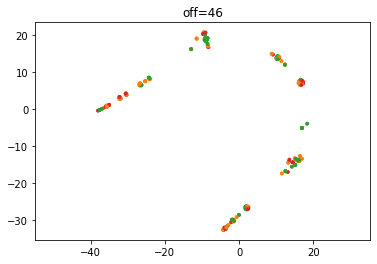

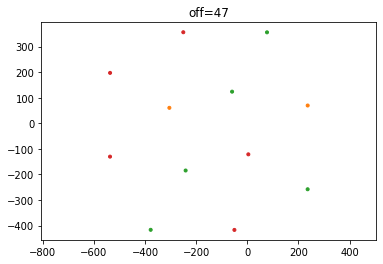

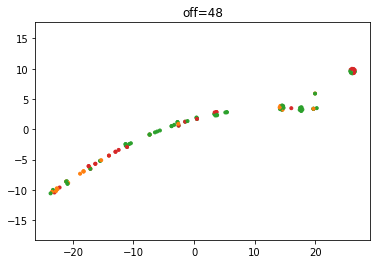

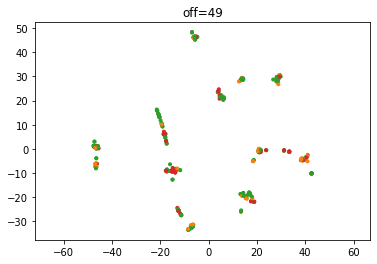

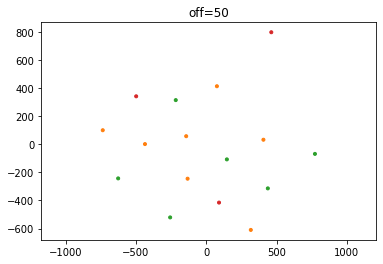

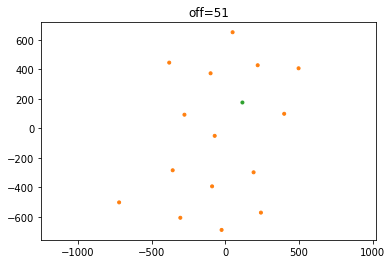

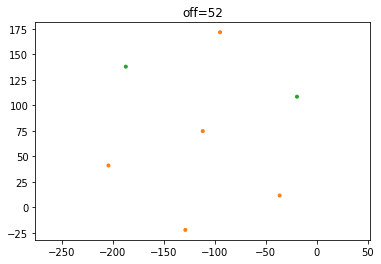

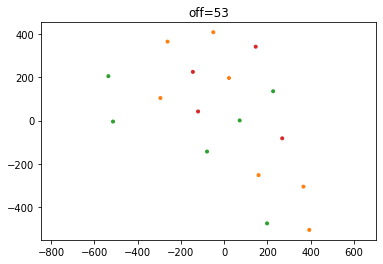

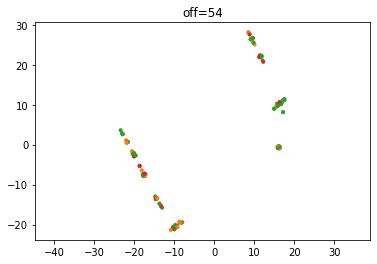

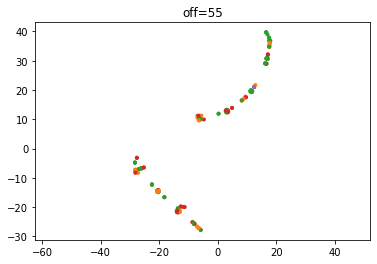

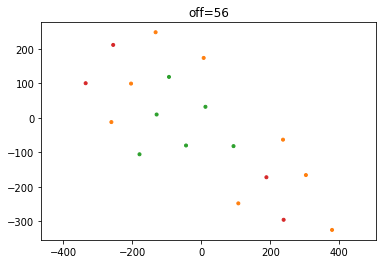

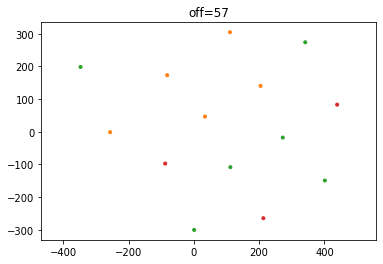

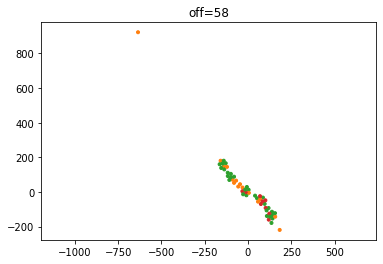

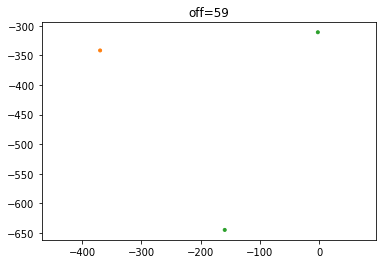

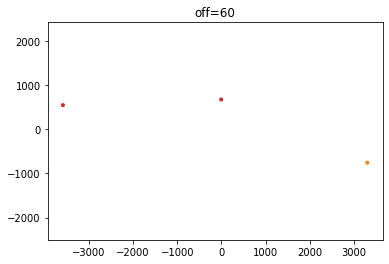

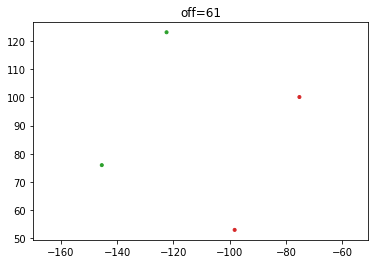

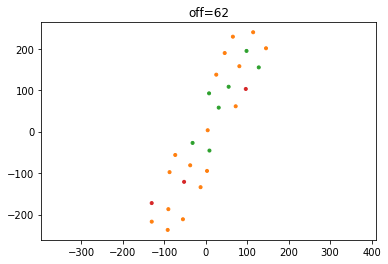

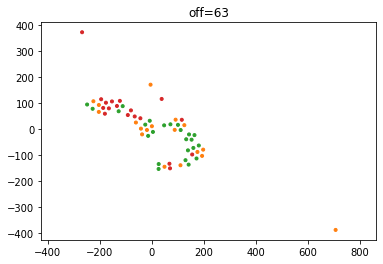

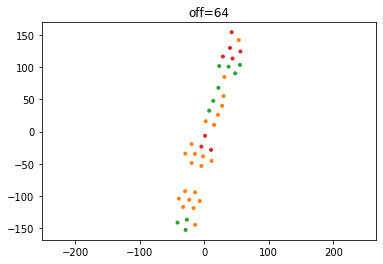

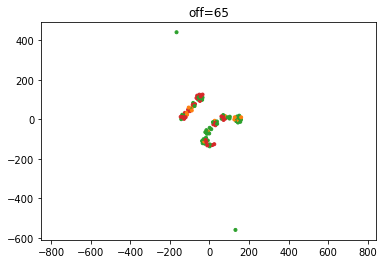

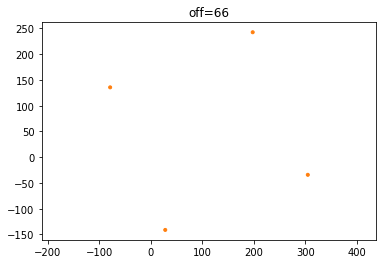

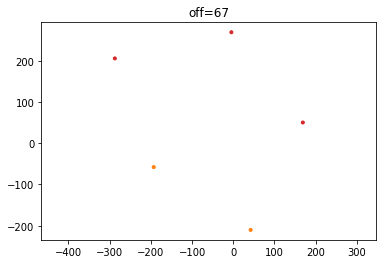

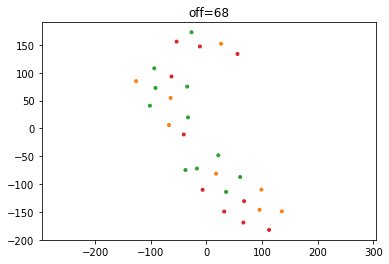

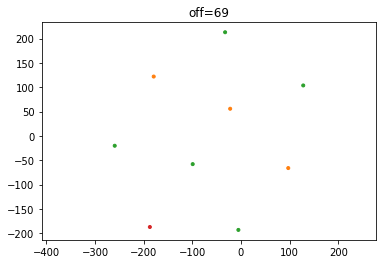

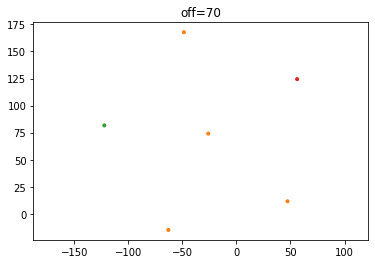

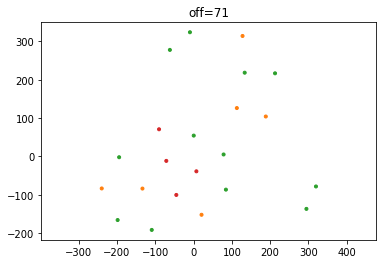

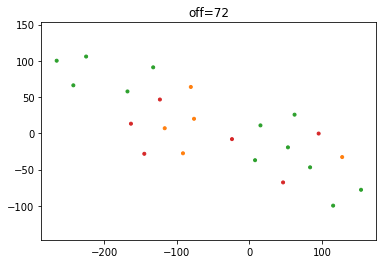

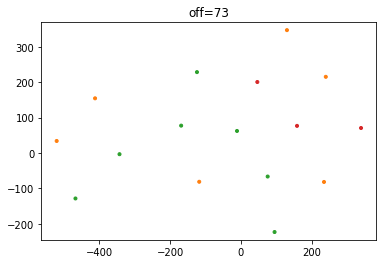

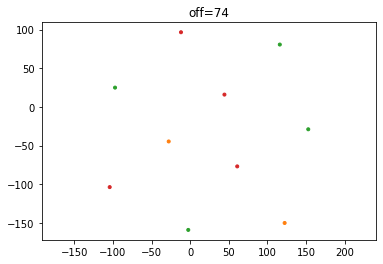

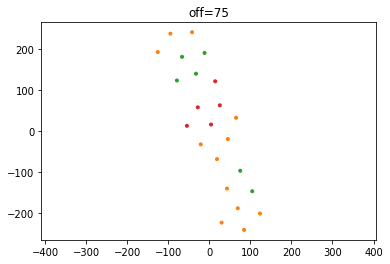

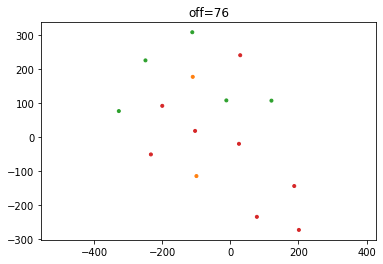

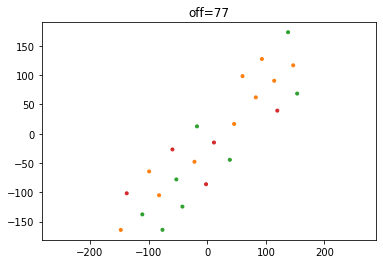

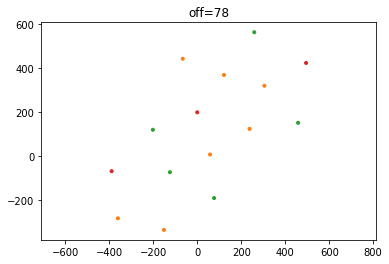

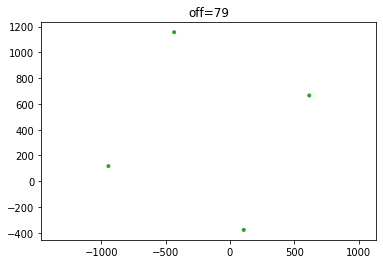

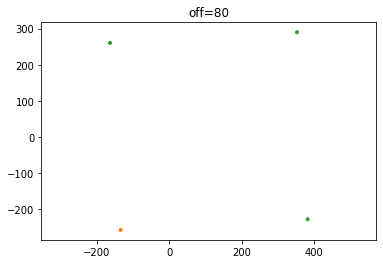

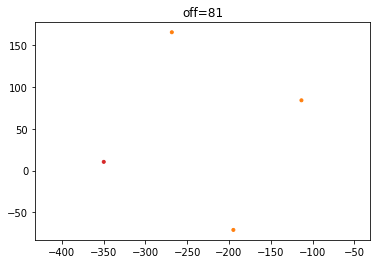

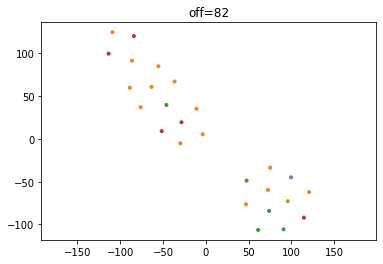

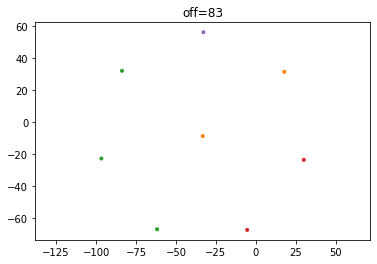

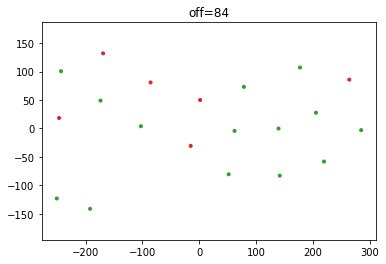

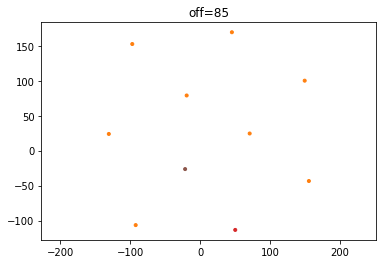

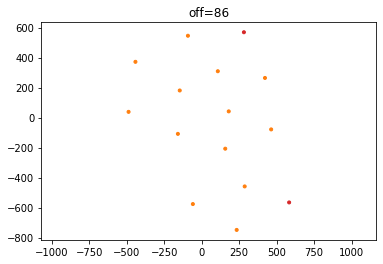

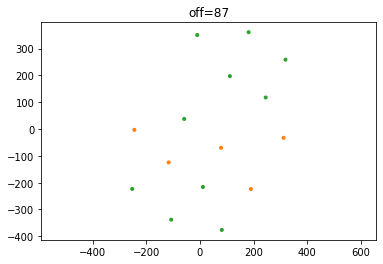

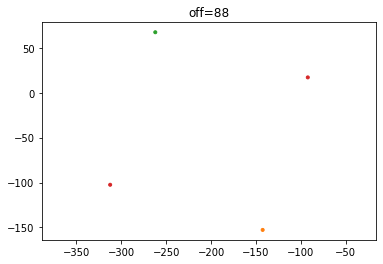

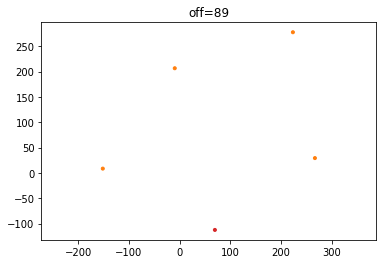

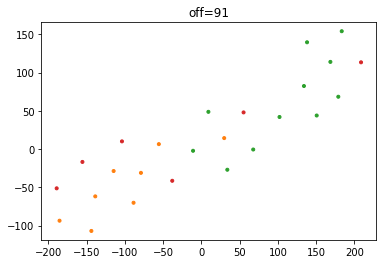

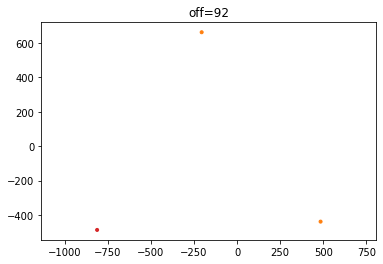

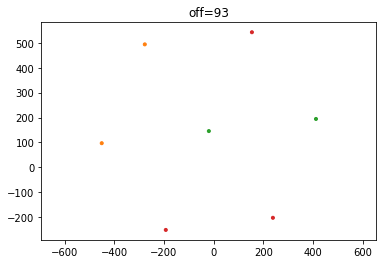

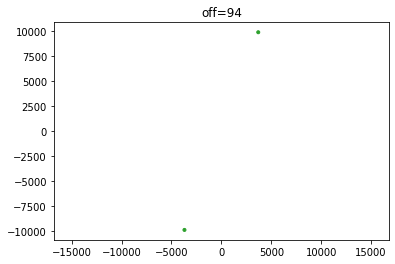

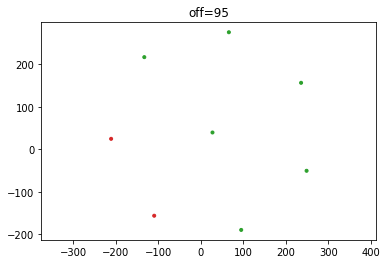

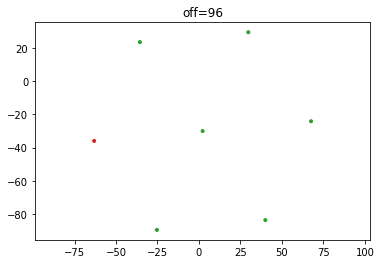

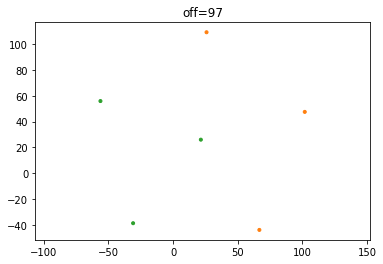

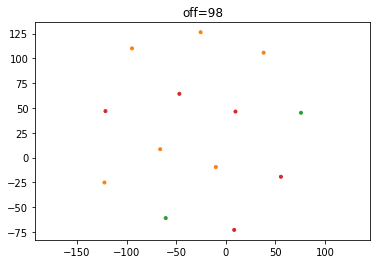

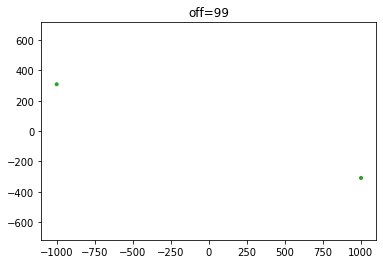

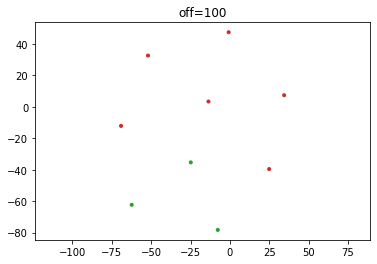

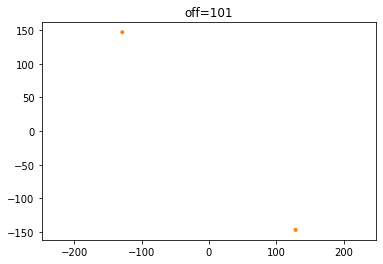

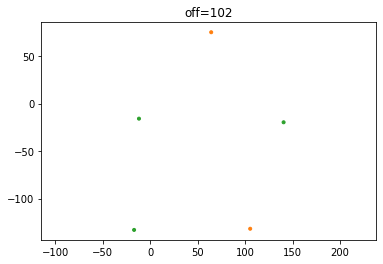

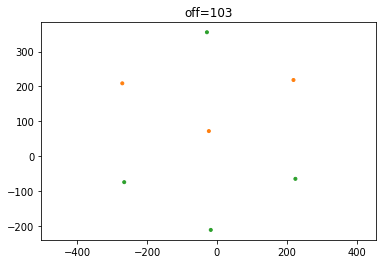

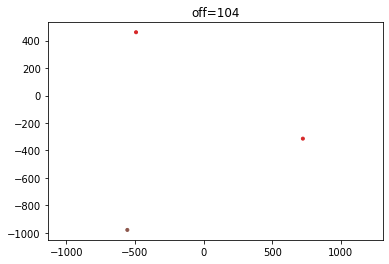

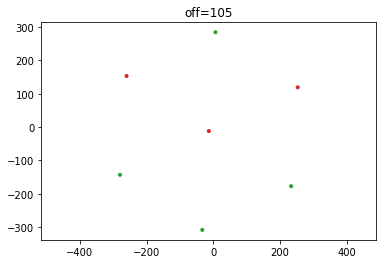

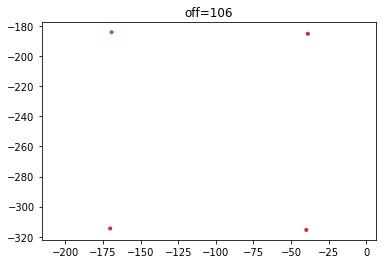

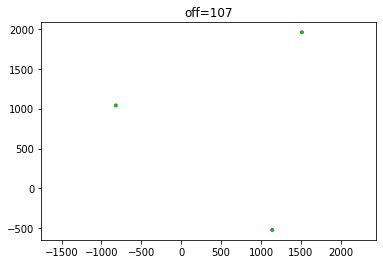

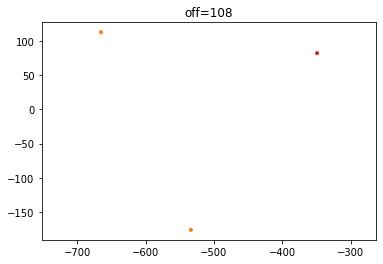

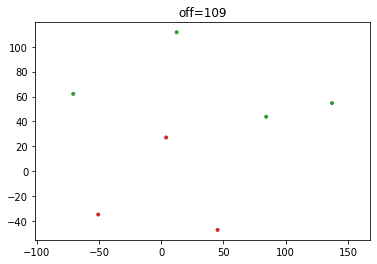

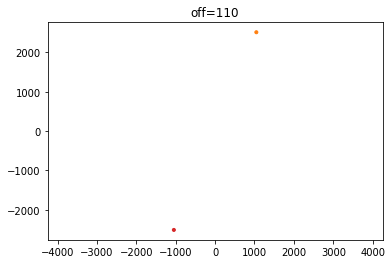

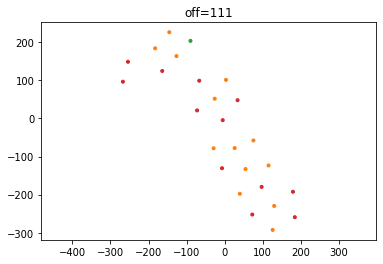

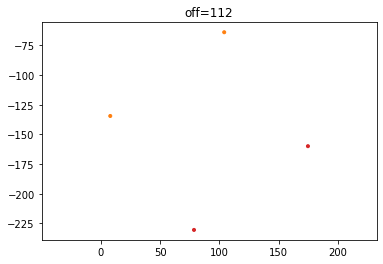

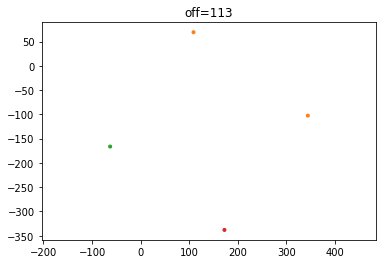

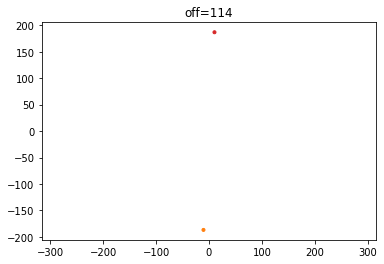

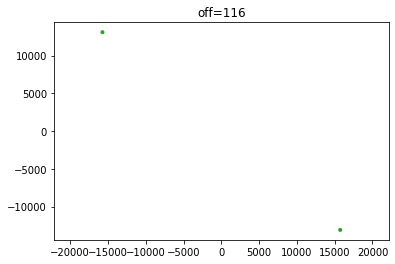

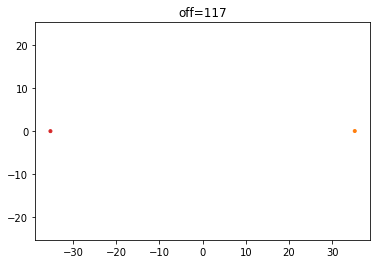

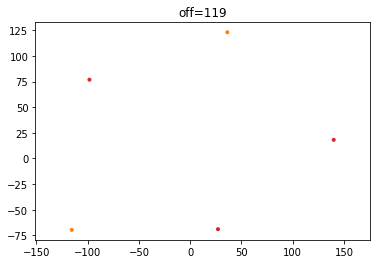

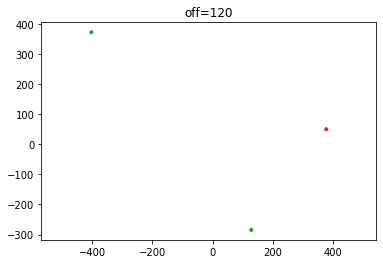

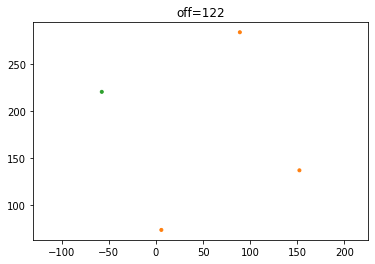

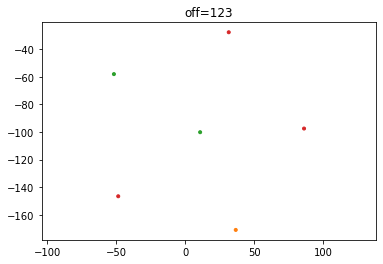

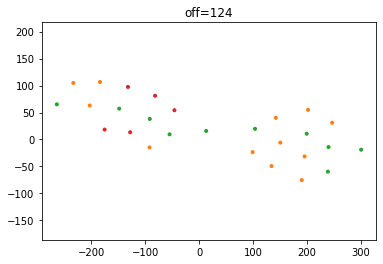

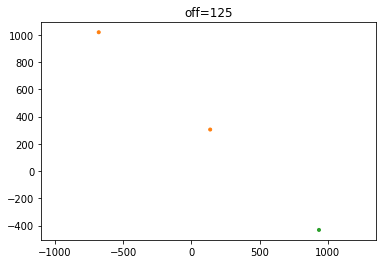

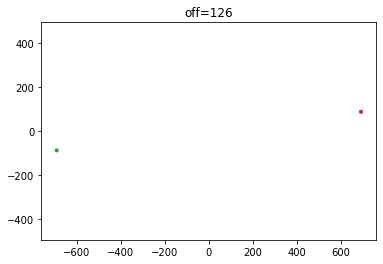

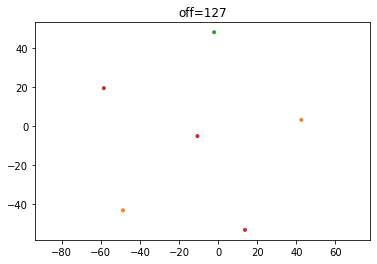

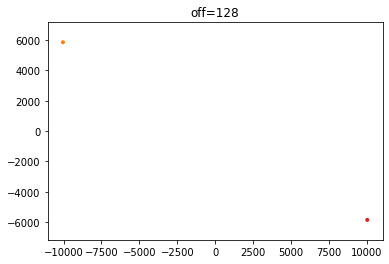

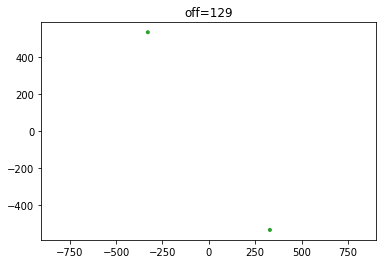

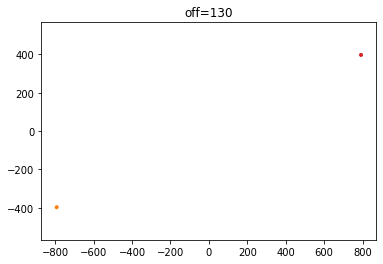

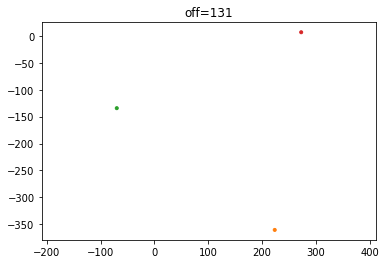

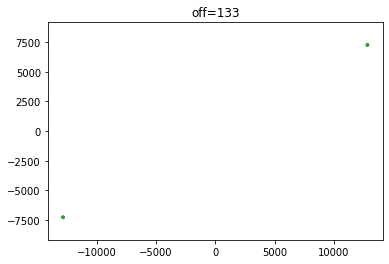

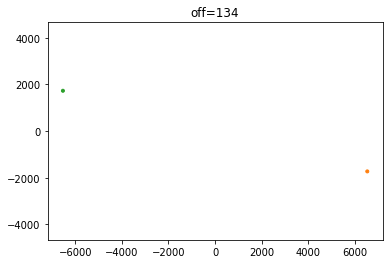

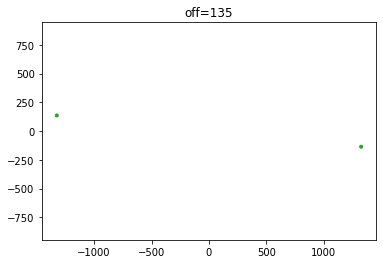

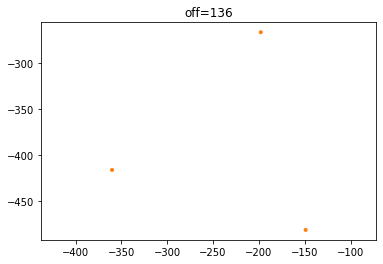

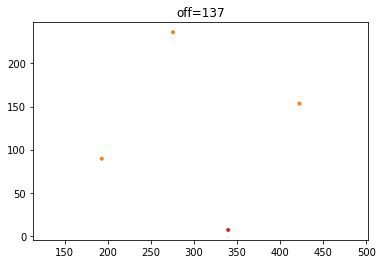

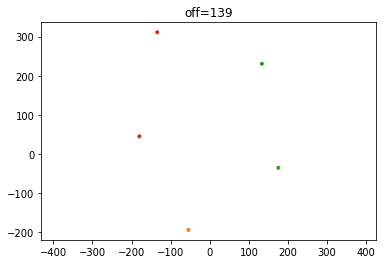

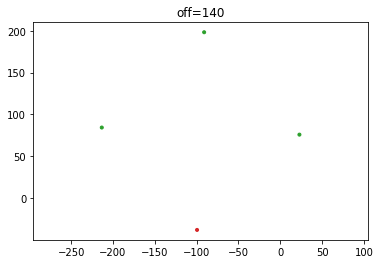

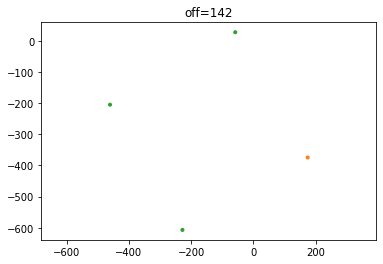

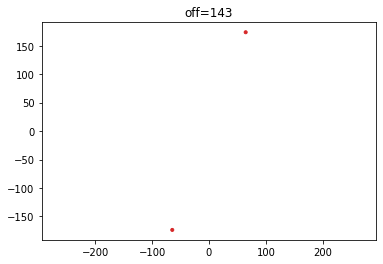

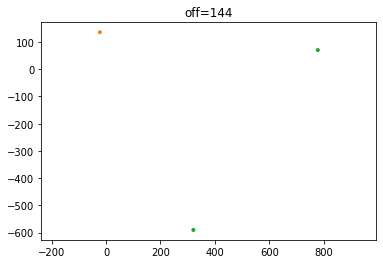

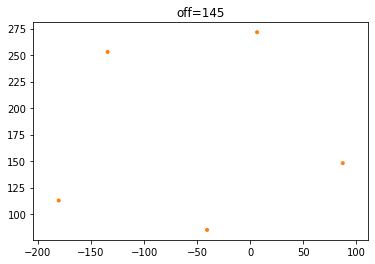

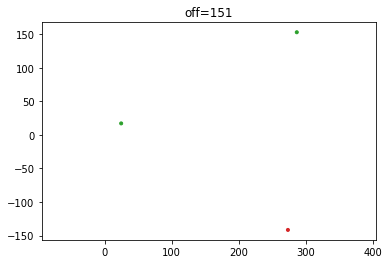

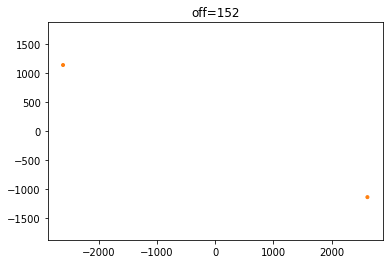

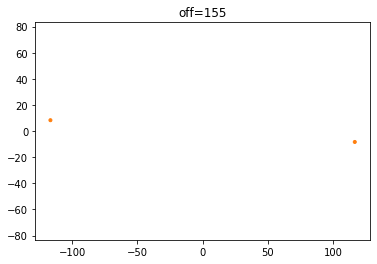

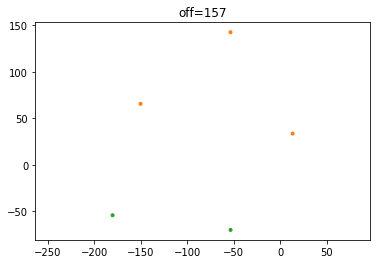

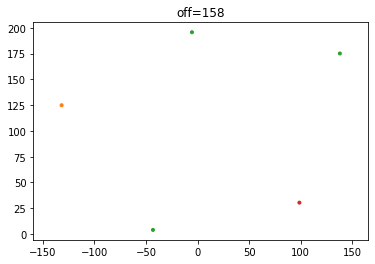

In [73]:
for off in set(samp.OFFENSE):
    
    mask = samp_X.OFFENSE == off
    
    data = samp_X[mask]
    
    try:
        trans = TSNE(perplexity=12).fit_transform(data)

        plt.scatter(trans[:, 0], trans[:, 1], c=[sns.color_palette()[x] for x in samp_y[mask]], marker='.')
        plt.gca().set_aspect('equal', 'datalim')
        plt.title(f'off={off}')
        plt.show()
    except:
        
        continue
    
    

TSNE is having mized results while UMAP doesn't seem to capture any good groupings. Maybe I should go straight to kmeans or kdtrees\\
I should block by crime and examine a few "big" crimes the try several different perplexities.
